In [84]:
#Nov 22, 2023

#This script looks at trends in hourly ozone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import seaborn as sns
import os

mpl.rcParams['figure.dpi'] = 200



### INPUT ###

# ap2014_path = '/content/drive/MyDrive/colab/consulting/mv/Data Package 1of2.xlsx'
# ap2024_path = '/content/drive/MyDrive/colab/consulting/mv/Data Package 2of2.xlsx'
ap2014_path = '/content/drive/MyDrive/colab/consulting/mv/O3_2002-2012.xlsx'
ap2024_path = '/content/drive/MyDrive/colab/consulting/mv/O3_2013-2023.xlsx'
meta_path = '/content/drive/MyDrive/colab/consulting/mv/SelectMeta.xlsx'

fig_path = '/content/drive/MyDrive/colab/consulting/mv/figs/task1'


# stations = ['T012','T031']  #testing
stations = ['T009','T012','T014','T018','T026','T027','T029','T030','T031','T034','T043','T044','T045'] #based on metro vancouver
# MV_stns = ['T009','T012','T014','T018','T026','T027','T029','T030','T031','T034/0345','T043','T044']
# stations =
quantiles = [0.5, 0.75, 0.95]
lmt_1h = [[5,35], [15,40], [30,50]]  #plot limits for 1h plots
lmt_8h = [[5,35], [15,40], [30,45]]  #plot limits for 1h plots


### end of input ###




In [85]:
#import data
ap2014 = pd.read_excel(ap2014_path,\
                      header=2, index_col=0, skiprows = lambda x: x in [3, 4], \
                       na_values=['NoData','Calib','<Samp','Zero','Down','InVld','Span','RS232','AutoCal','Purge','Spare'])


In [86]:
ap2024 = pd.read_excel(ap2024_path,\
          header=2, index_col=0, skiprows = lambda x: x in [3, 4], \
                       na_values=['NoData','Calib','<Samp','Zero','Down','InVld','Span','RS232','AutoCal','Purge','Spare'])

In [87]:
#import metadata
meta = pd.read_excel(meta_path)
meta['MV_ID'] = meta.MV_ID.apply(lambda x: 'T' + x[1:].zfill(3))
meta.set_index(meta.MV_ID, inplace=True)
meta.index.rename('stations', inplace=True)
meta.convert_dtypes()
#add merged TYXX station
meta.loc['TYXX','Lat'] = meta.loc[['T034','T045'], 'Lat'].mean()
meta.loc['TYXX','Lon'] = meta.loc[['T034','T045'], 'Lon'].mean()
meta.loc['TYXX','StationName'] = 'ABBOTSFORD AP MERGED'

In [88]:
#convert index to datetime and data to float
ap2014.index = pd.to_datetime(ap2014.index)
ap2014.convert_dtypes()
# ap2014['jday'] = ap2014.index.day_of_year

ap2024.index = pd.to_datetime(ap2024.index)
ap2024.convert_dtypes()
# ap2024['jday'] = ap2024.index.day_of_year


T009  T012  T014  T018  T026  T027  T029  T030  T031  \
Date & Time                                                                 
2013-01-01 00:00:00   4.2   2.3  20.0   0.4   1.6   0.9  14.1   5.7   0.1   
2013-01-01 01:00:00   6.5   1.3  18.9   1.8   0.6   0.7  14.5   6.8   0.2   
2013-01-01 02:00:00  10.6   1.5  20.7   3.7   3.5   1.0  15.3   5.1   0.2   
2013-01-01 03:00:00  <NA>  <NA>  <NA>  <NA>  <NA>   1.2  15.7   3.9   1.4   
2013-01-01 04:00:00  10.0   9.0  22.4   5.0   3.8   3.1  15.3   2.3   0.5   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2023-12-31 19:00:00  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
2023-12-31 20:00:00  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
2023-12-31 21:00:00  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
2023-12-31 22:00:00  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
2023-12-31 23:00:00  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   

                     T043  T044  T045  
Date & Time                            
2013-01-01 00:00:00  <NA>  <NA>   1.7  
2013-01-01 01:00:00  <NA>  <NA>   0.5  
2013-01-01 02:00:00  <NA>  <NA>   0.5  
2013-01-01 03:00:00  <NA>  <NA>  <NA>  
2013-01-01 04:00:00  <NA>  <NA>   1.8  
...                   ...   ...   ...  
2023-12-31 19:00:00  <NA>  <NA>  <NA>  
2023-12-31 20:00:00  <NA>  <NA>  <NA>  
2023-12-31 21:00:00  <NA>  <NA>  <NA>  
2023-12-31 22:00:00  <NA>  <NA>  <NA>  
2023-12-31 23:00:00  <NA>  <NA>  <NA>  

[96408 rows x 12 columns]

In [89]:
#assemble data, do grouping and averaging
ozone_1h = pd.concat([ap2014, ap2024])

#create a merged station for TYXX and drop originals
ozone_1h['TYXX'] = ozone_1h.T034.combine_first(ozone_1h.T045)
ozone_1h.drop(['T034','T045'],axis=1,inplace=True)
stations = stations + ['TYXX']
stations = [i for i in stations if i not in ['T034','T045']]

grp_1h = ozone_1h.groupby(ozone_1h.index.year)
ozone_8h = ozone_1h.rolling(8, min_periods=6).mean()
grp_8h = ozone_8h.groupby(ozone_8h.index.year)

In [ ]:
#-----optional: check for random missing data strings-------
# pd.to_numeric(ozone_1h.T026)

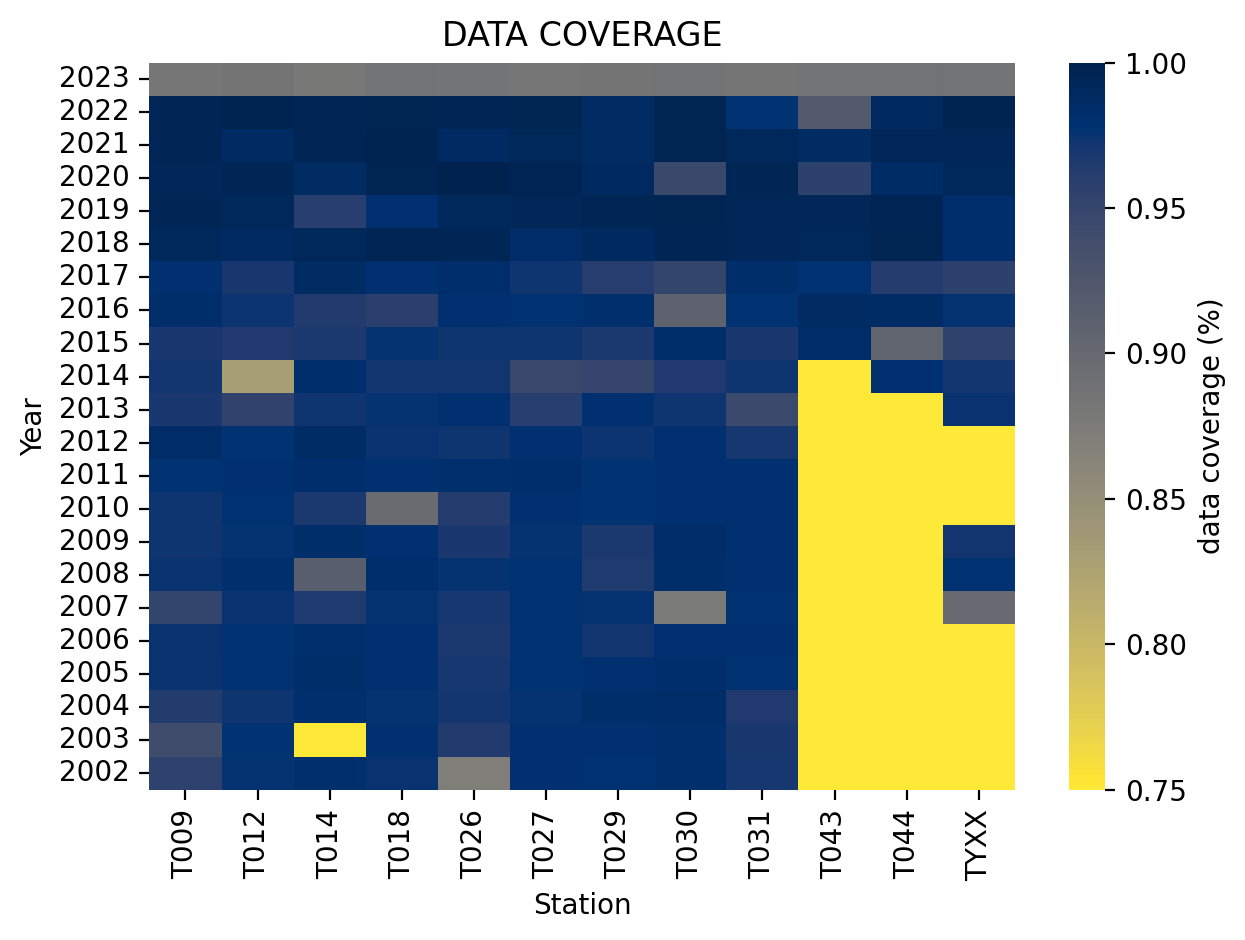

In [90]:
#look at how complete the data is
data_frac = grp_1h.count()/8760
plt.figure()
ax = plt.gca()
sns.heatmap(data_frac, vmin=0.75, vmax=1,cmap='cividis_r',cbar_kws={'label': 'data coverage (%)'})
ax.set(ylabel='Year', xlabel='Station', title='DATA COVERAGE')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(fig_path,'data_coverage.pdf'))

In [94]:
# #sanity check: outlier check
# ozone_1h.boxplot()

In [95]:
# set up storage dataframe for trends
trends = pd.DataFrame(columns = ('stations','1h0.5','1h0.75','1h0.95','8h0.5','8h0.75','8h0.95','lat','lon'))
trends['stations'] = stations
trends.set_index(trends.stations, inplace=True)


No 1h data to perform OLS: T043 for AP2014 Q50
No 1h data to perform OLS: T043 for AP2014 Q75
No 1h data to perform OLS: T043 for AP2014 Q95
No 1h data to perform OLS: T044 for AP2014 Q50
No 1h data to perform OLS: T044 for AP2014 Q75
No 1h data to perform OLS: T044 for AP2014 Q95


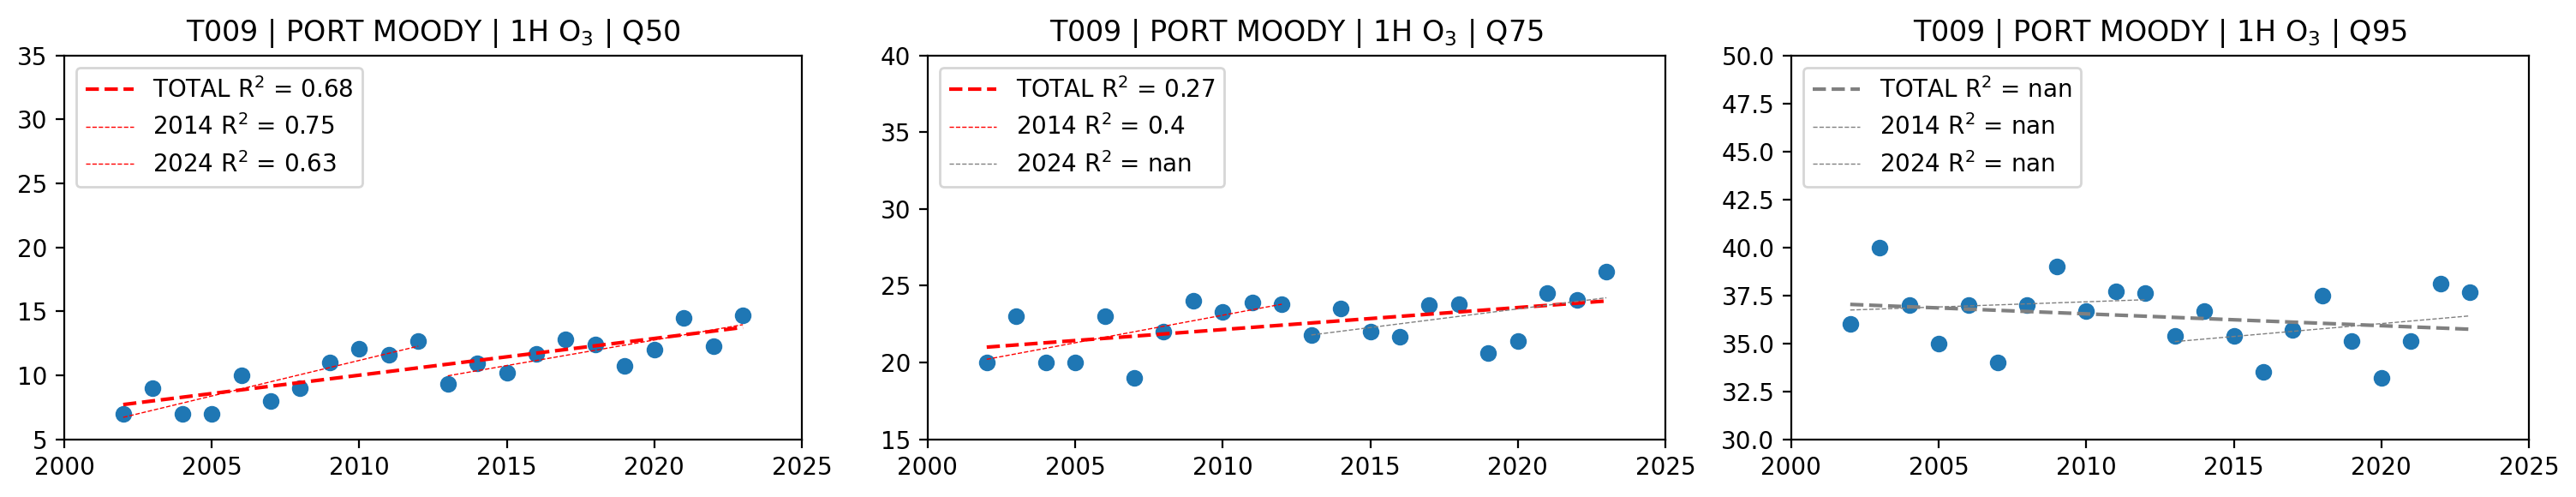

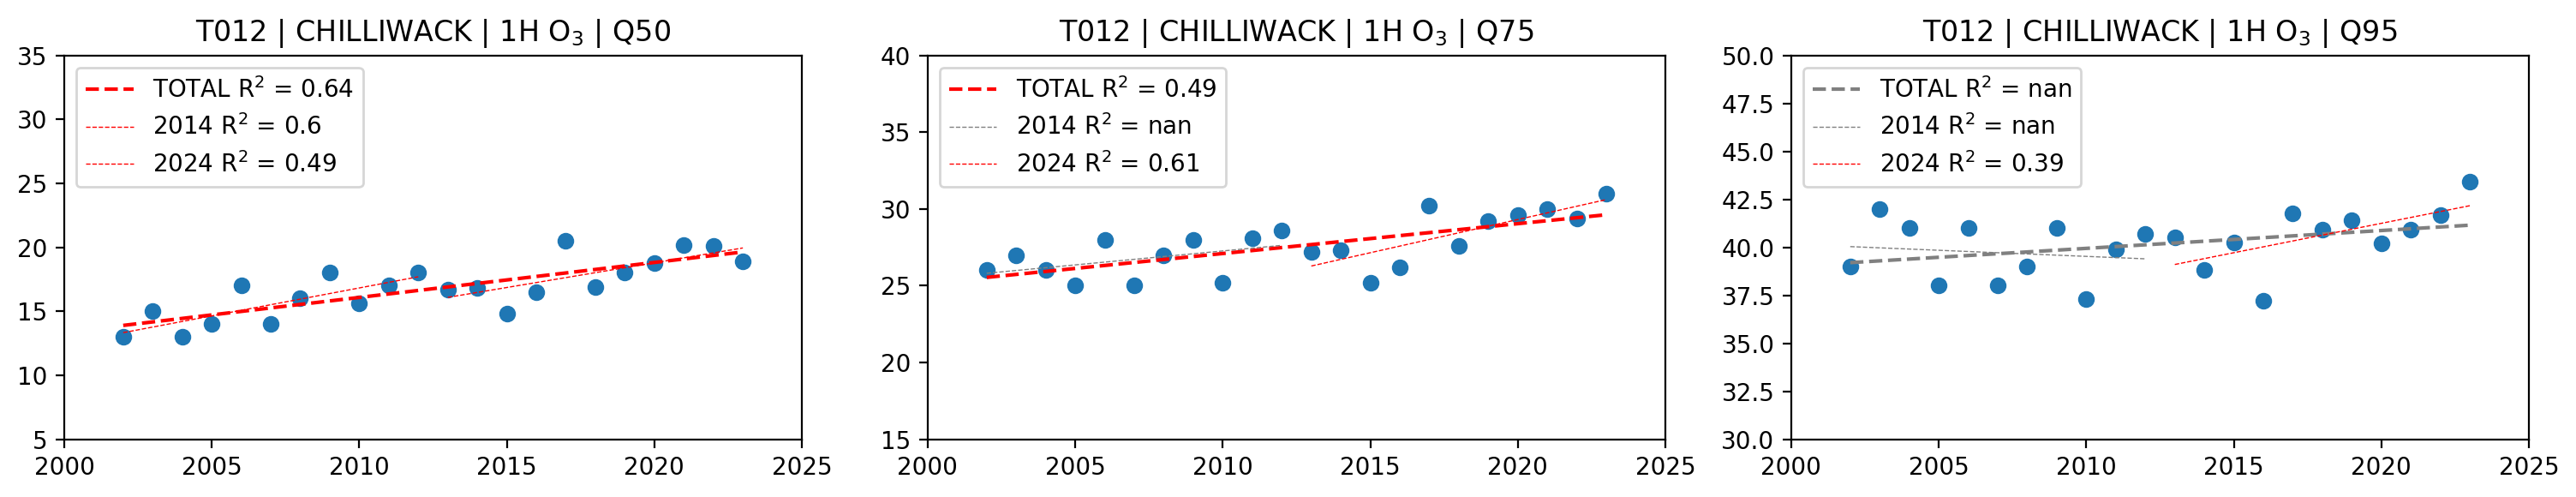

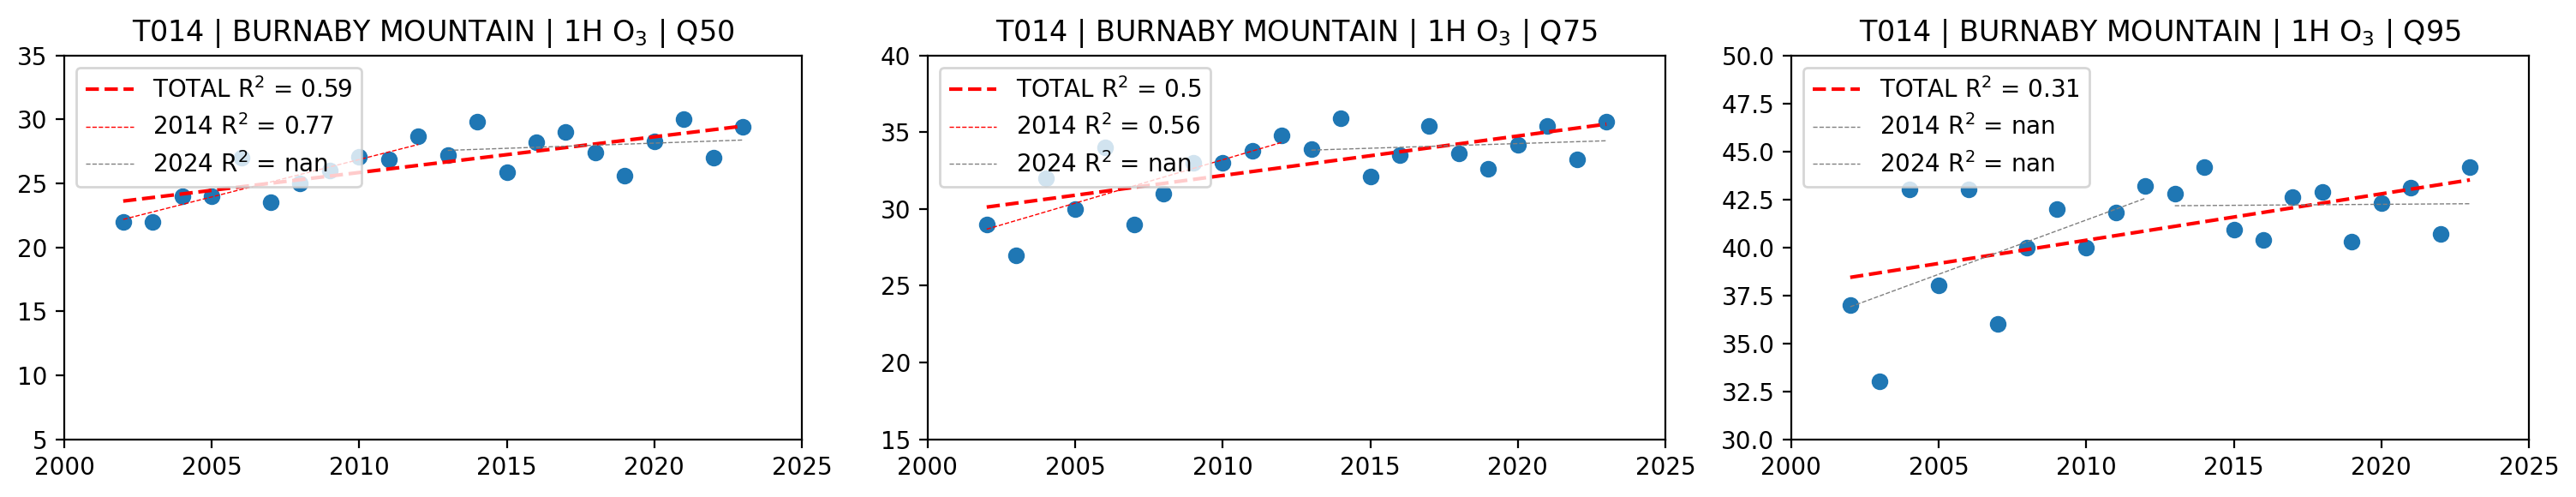

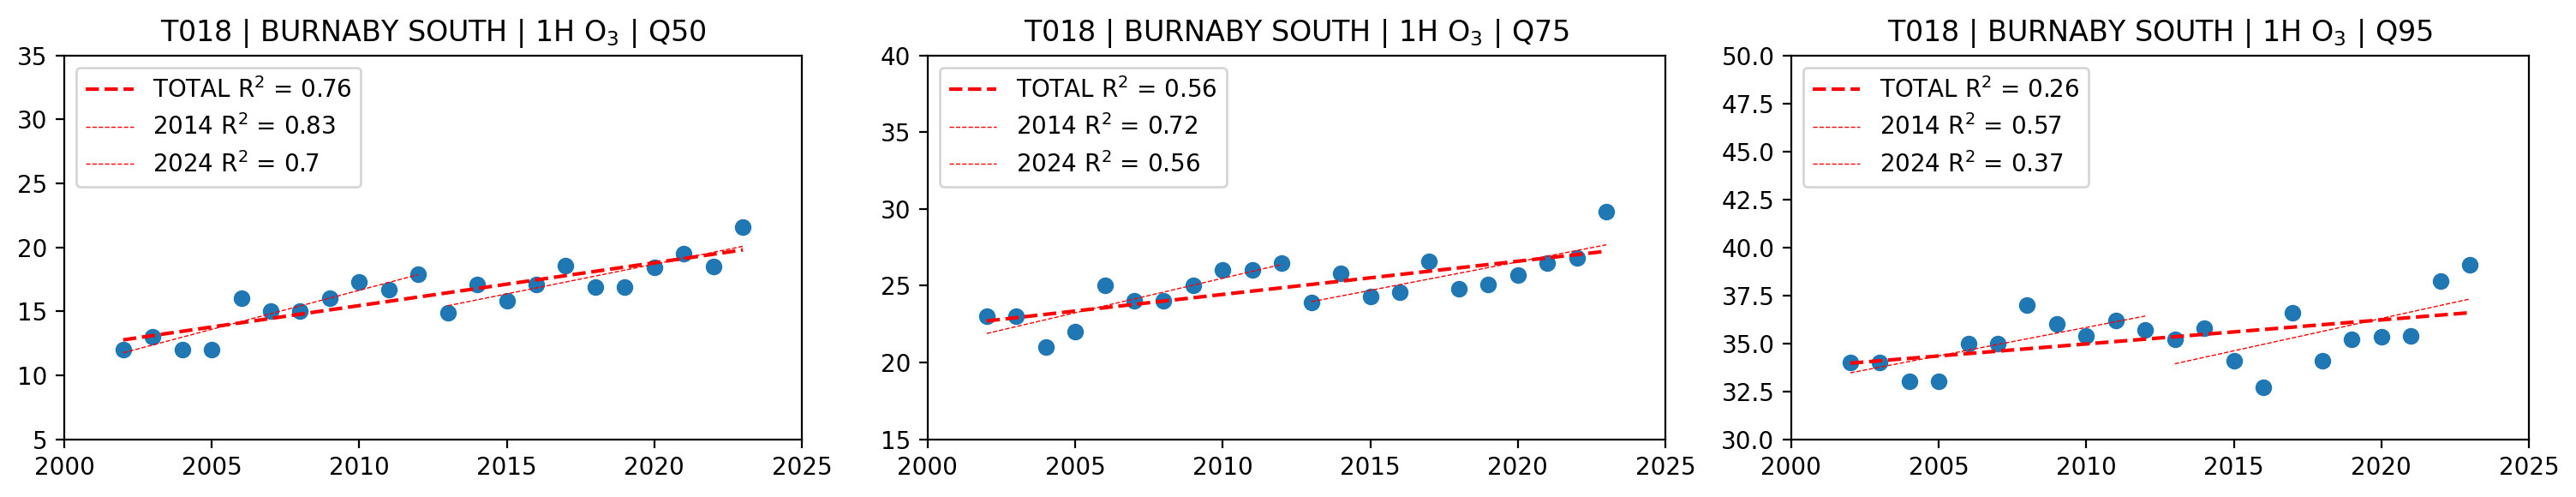

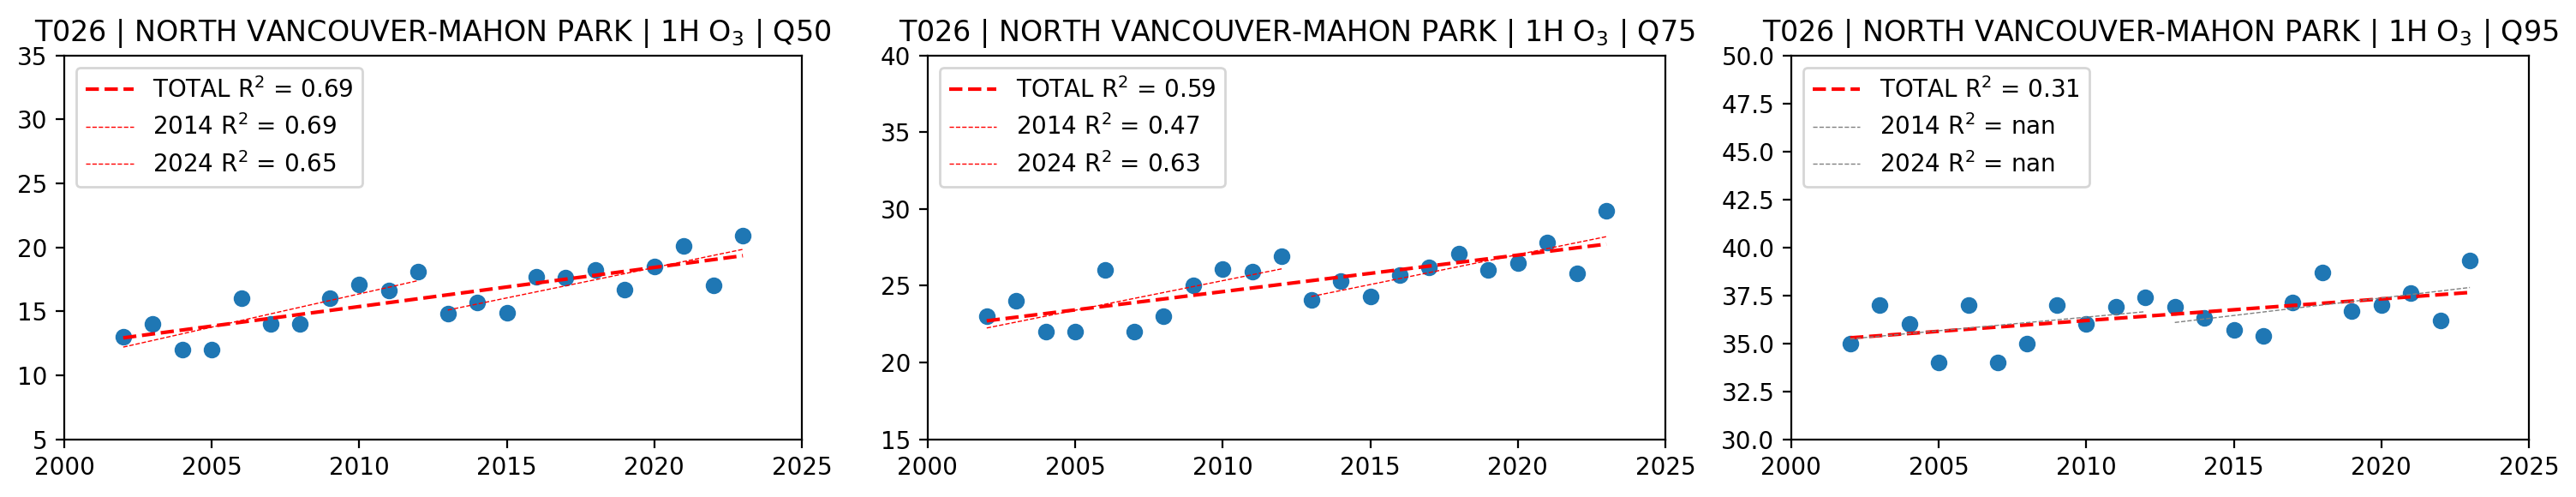

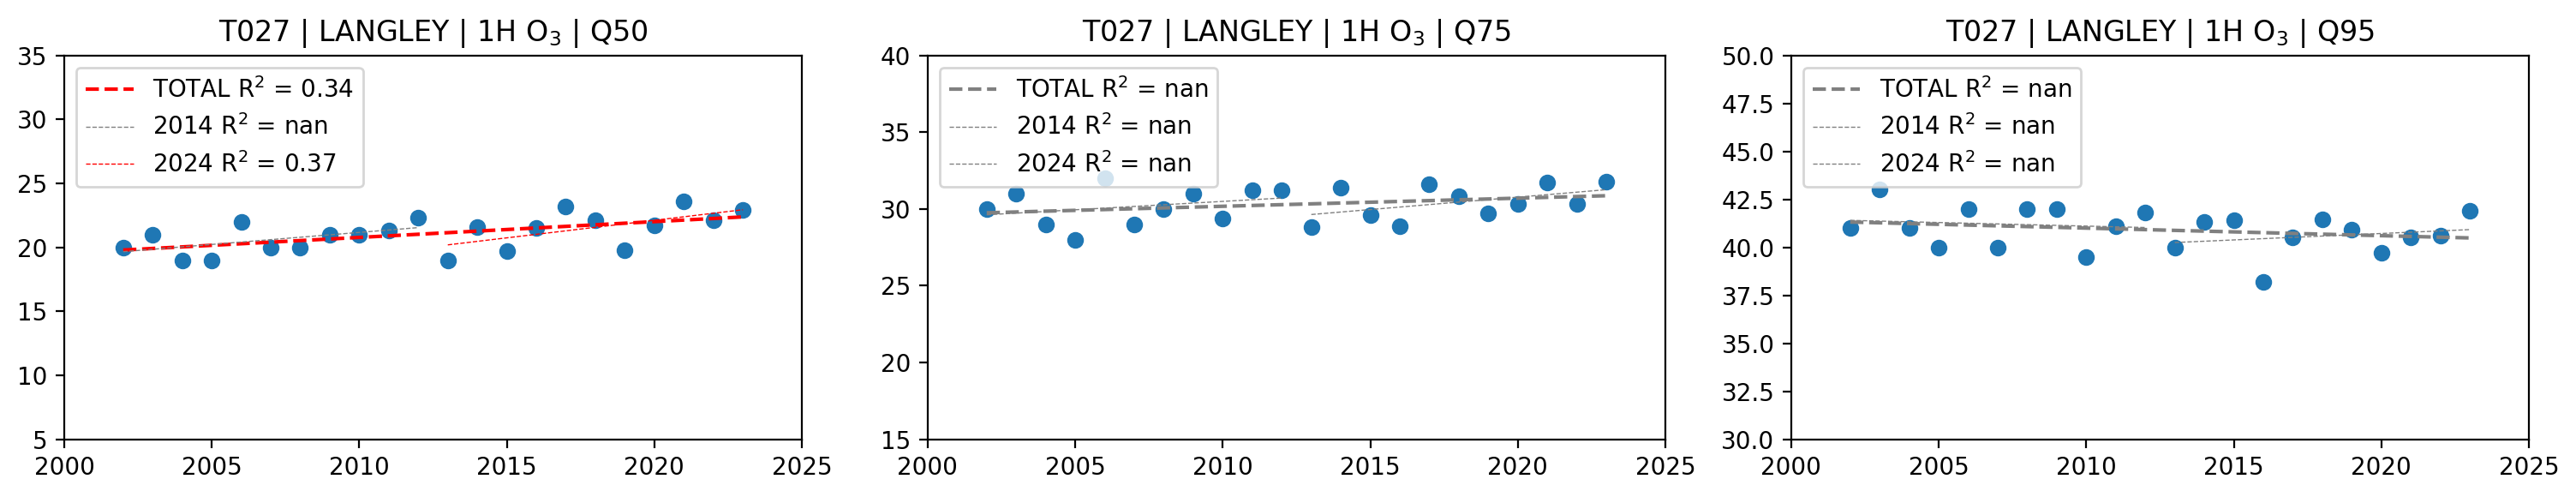

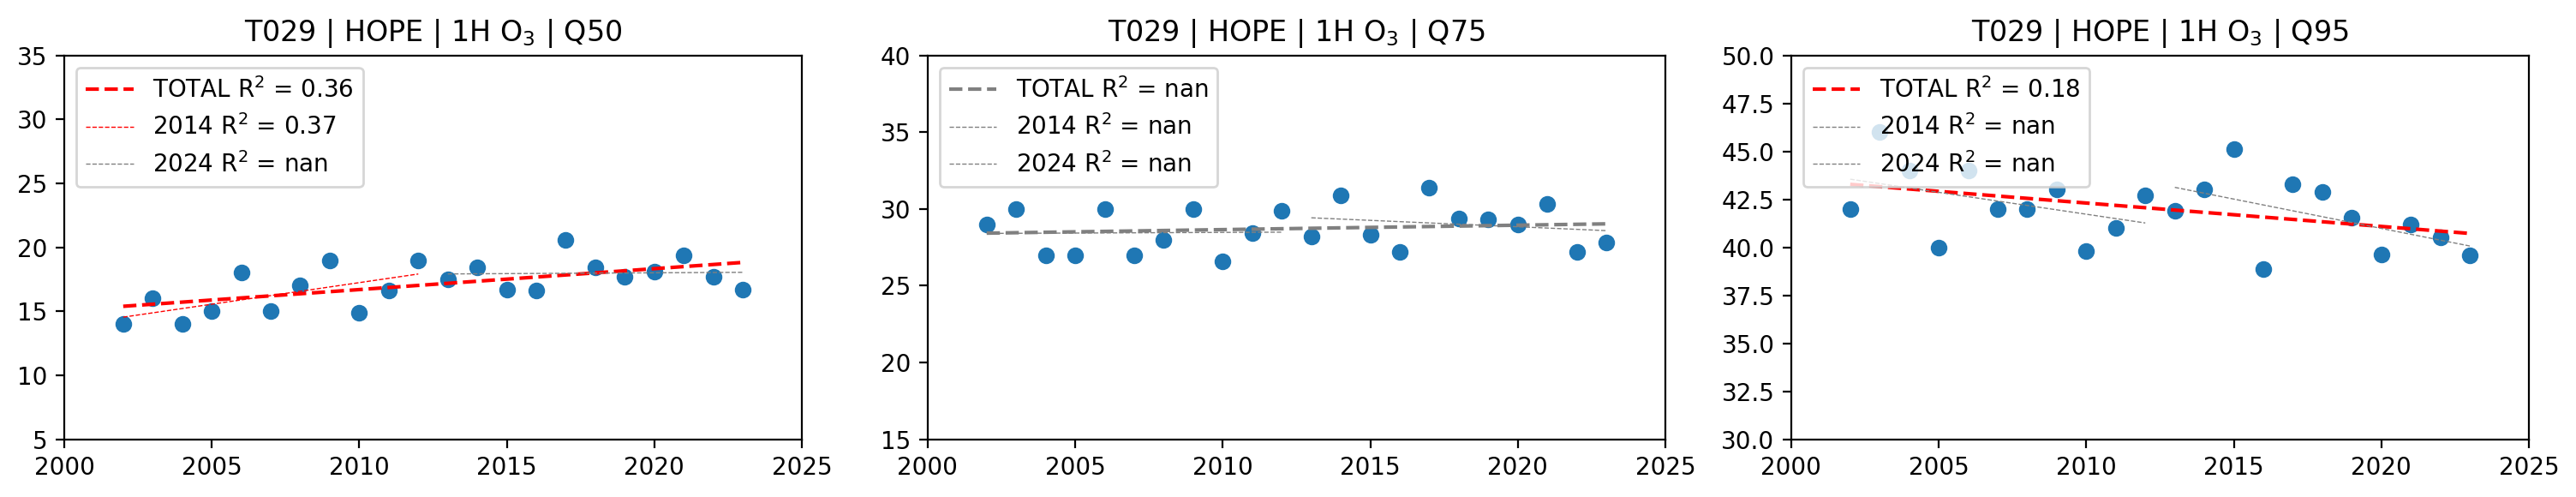

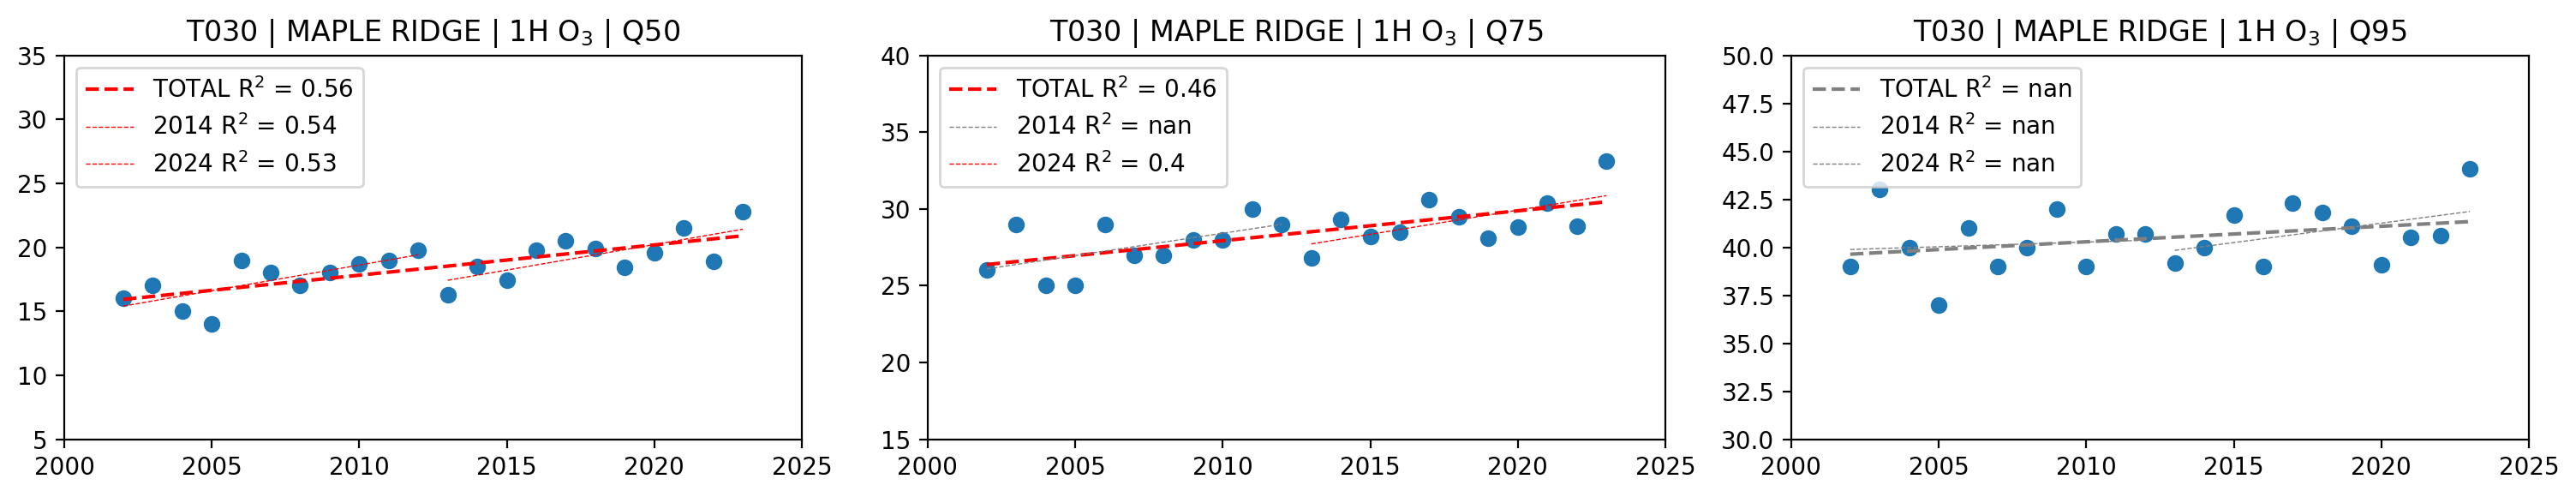

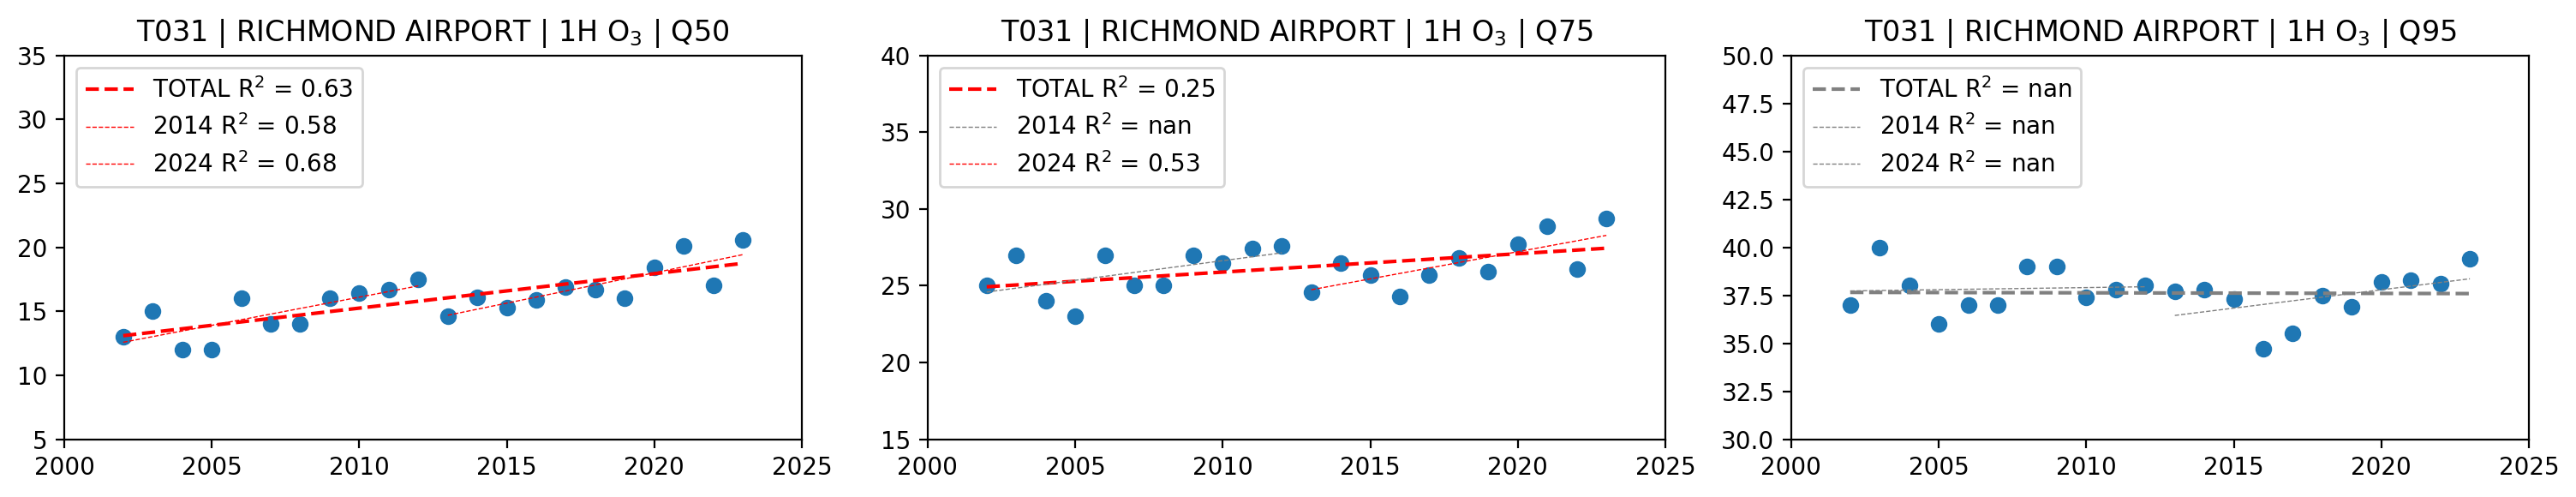

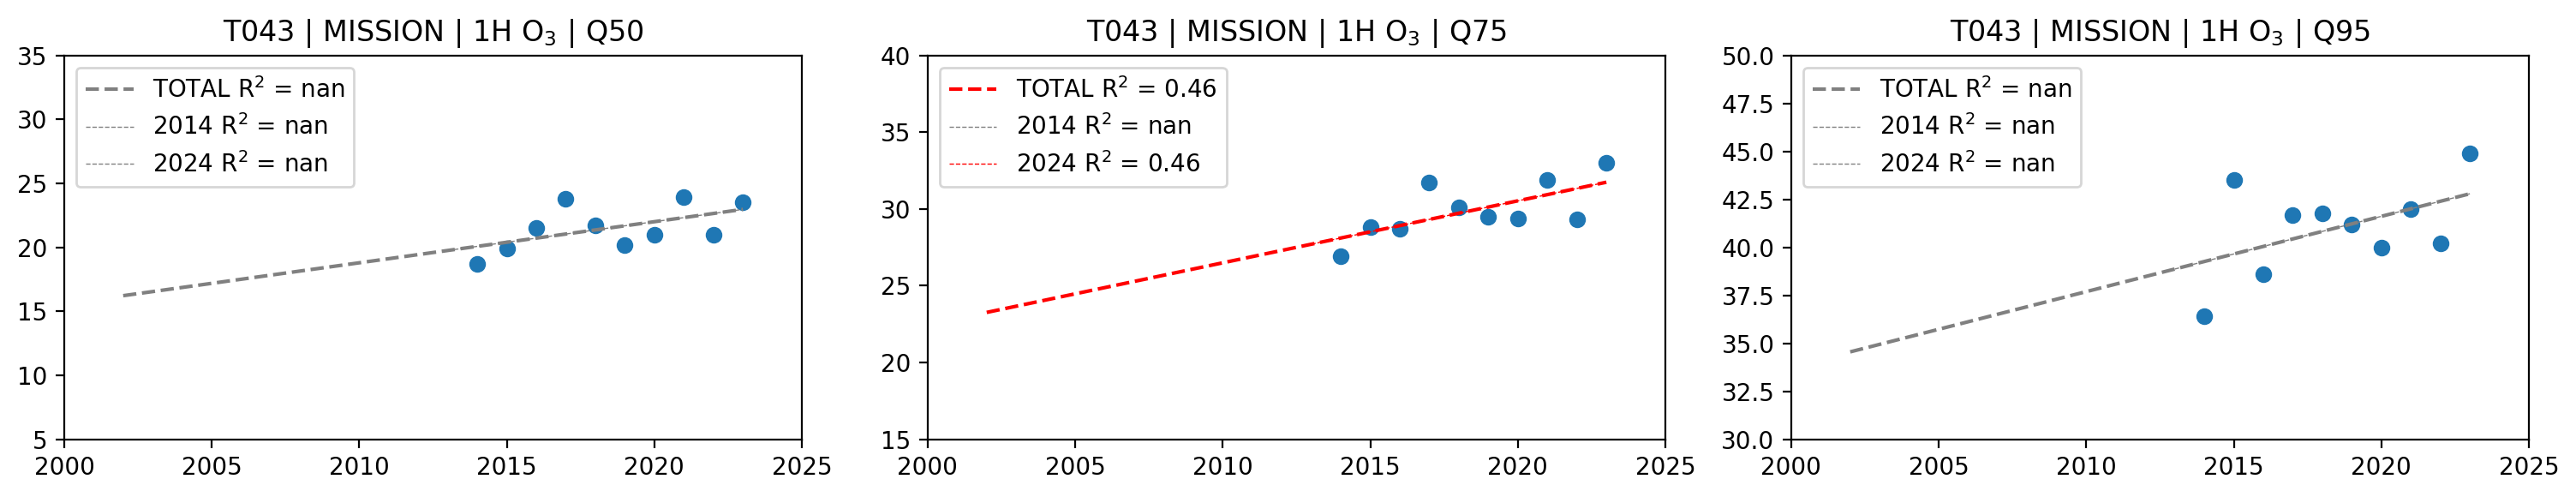

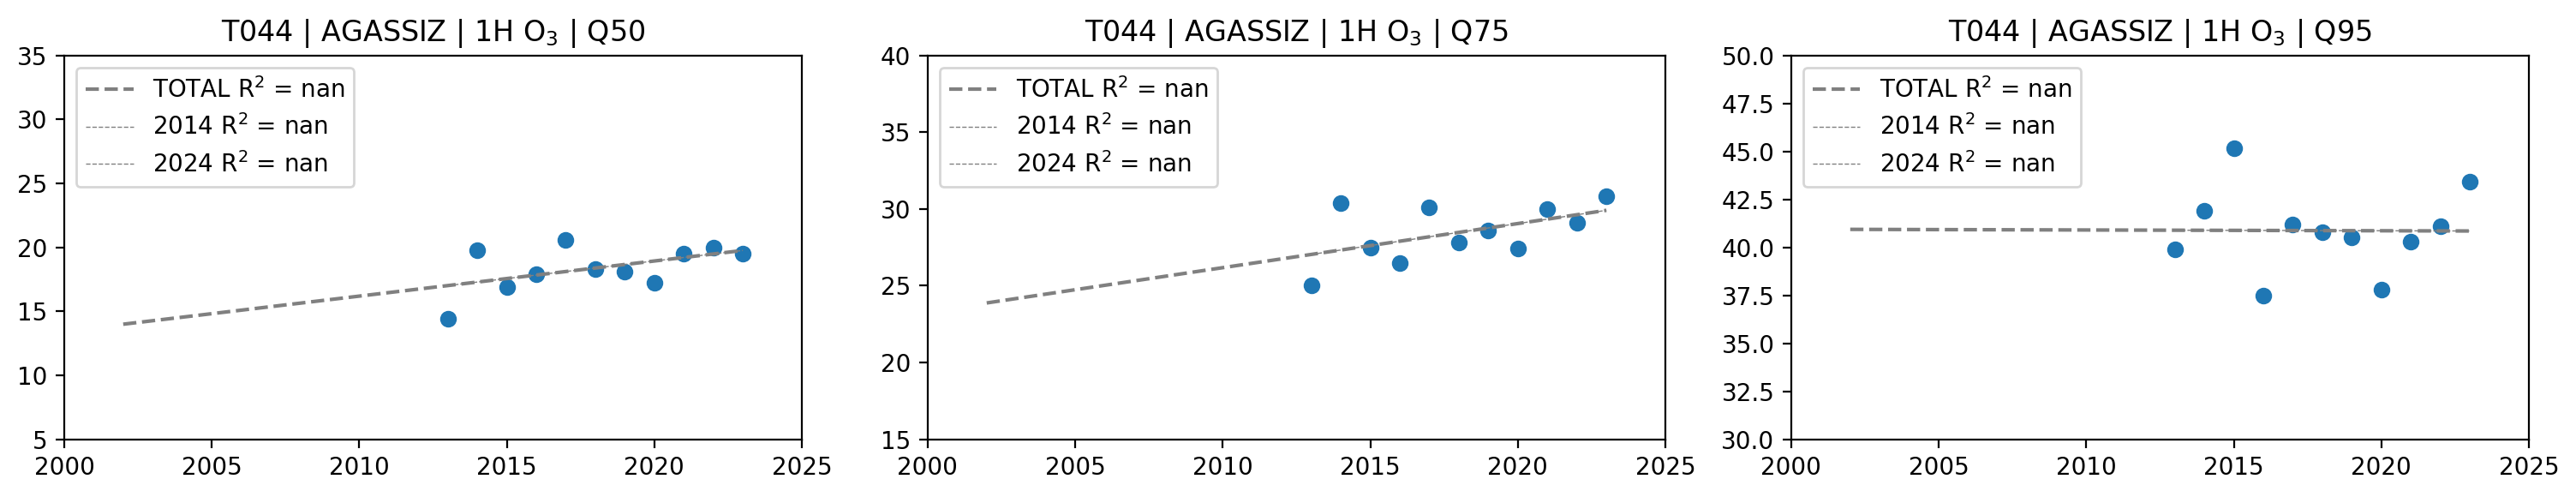

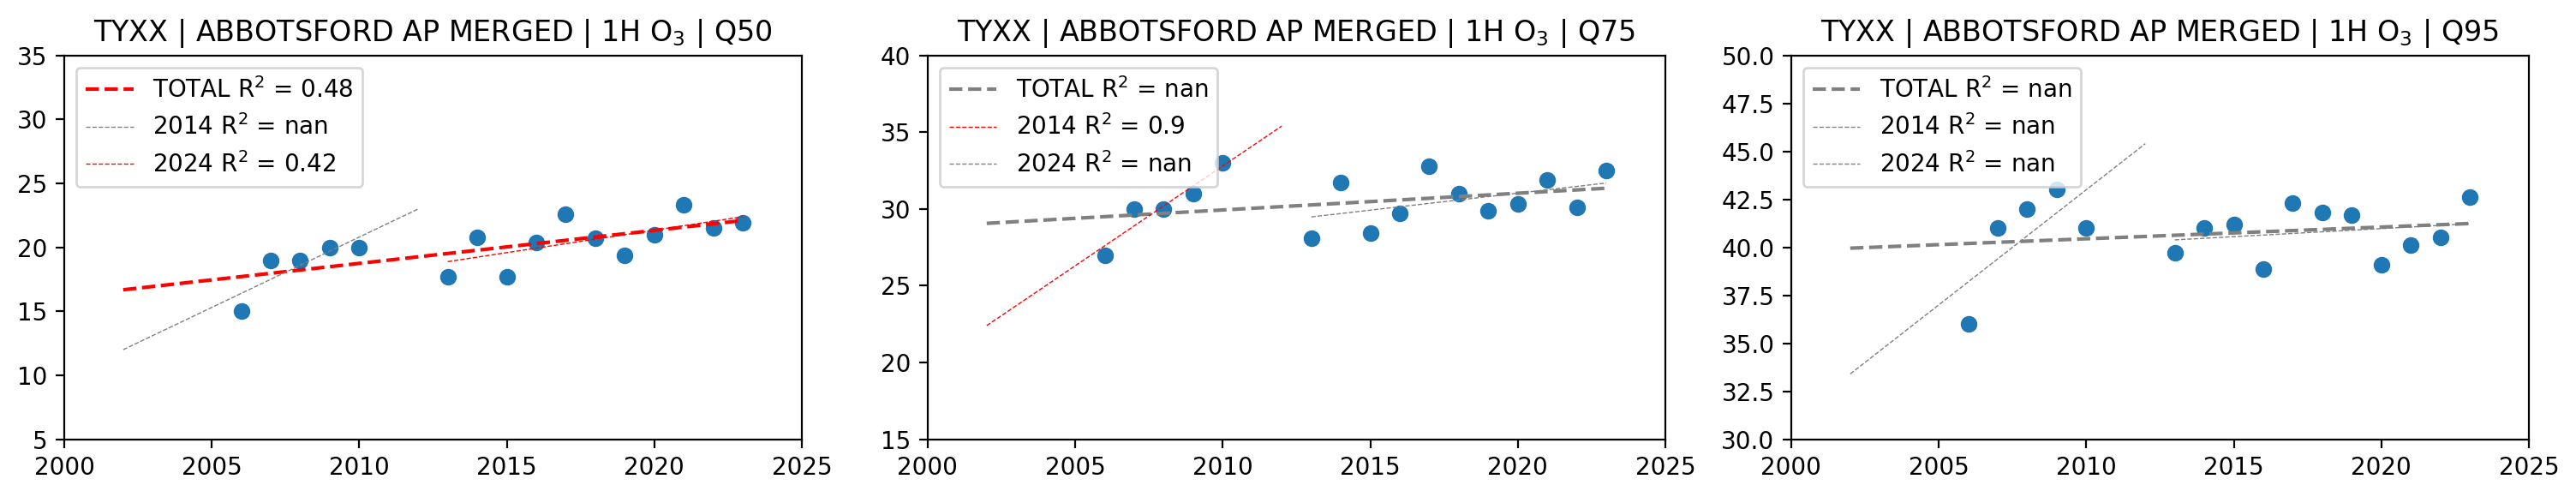

In [96]:
 #-------------1H OZONE------------------

#loop through stations
for nStn, stn in enumerate(stations):

  #loop through quantiles
  numQnt = len(quantiles) + 1
  plt.figure(figsize=(5*numQnt,3))
  for nQ, qnt in enumerate(quantiles):

    #gather data
    q = grp_1h[stn].quantile(q=qnt)

    #------trendline------
    #add constant to predictor variables
    x = sm.add_constant(q.index.values)
    #fit linear regression model
    modelT = sm.OLS(q, x, missing='drop').fit()
    try:
      model2014 = sm.OLS(q[:11], x[:11], missing='drop').fit()
      trend2014 = model2014.predict(exog=x[:11])
    except:
      trend2014 = np.ones(np.shape(q[:11])) * np.nan
      print(f'No 1h data to perform OLS: {stn} for AP2014 Q{int(qnt*100)}')
    try:
      model2024 = sm.OLS(q[11:], x[11:], missing='drop').fit()
      trend2024 = model2024.predict(exog=x[11:])
    except:
      trend2024 = np.ones(np.shape(q[11:])) * np.nan
      print(f'No 1h data to perform OLS: {stn} for AP2024 Q{int(qnt*100)}')

    #get trend for last N years
    trendT = modelT.predict(exog=x)
    #if significant, save the trend
    if modelT.pvalues.x1<0.05:
      trends.loc[stn,f'1h{qnt}'] = modelT.params.x1
    trends.loc[stn,['lat','lon']] = meta.loc[stn,['Lat','Lon']].values


    #----plotting-----
    plt.subplot(1,numQnt,nQ + 1)
    ax = plt.gca()
    plt.scatter(y = q, x=q.index)
    plt.plot(x[:,1],trendT,c=['red' if modelT.pvalues.x1<0.05 else 'gray'][0],linestyle='--',\
             label = f'TOTAL R$^2$ = {[round(modelT.rsquared,2) if modelT.pvalues.x1<0.05 else "nan"][0]}')
    plt.plot(x[:11,1],trend2014,c=['red' if model2014.pvalues.x1<0.05 else 'gray'][0],\
             linestyle='--', linewidth = 0.5, \
             label = f'2014 R$^2$ = {[round(model2014.rsquared,2) if model2014.pvalues.x1<0.05 else "nan"][0]}')
    plt.plot(x[11:,1],trend2024,c=['red' if model2024.pvalues.x1<0.05 else 'gray'][0],\
             linestyle='--', linewidth = 0.5, \
             label = f'2024 R$^2$ = {[round(model2024.rsquared,2) if model2024.pvalues.x1<0.05 else "nan"][0]}')
    plt.legend(loc=2)
    ax.set(title = f'{stn} | {meta.loc[stn,"StationName"]} | 1H O$_3$ | Q{int(qnt*100)}', xlim=[2000, 2025], ylim=lmt_1h[nQ])
  plt.tight_layout()
  plt.savefig(os.path.join(fig_path, 'stn_trends','1H',f'{stn}_O3_1H.pdf'),bbox_inches = 'tight')


No 8h data to perform OLS: T043 for AP2014 Q50
No 8h data to perform OLS: T043 for AP2014 Q75
No 8h data to perform OLS: T043 for AP2014 Q95
No 8h data to perform OLS: T044 for AP2014 Q50
No 8h data to perform OLS: T044 for AP2014 Q75
No 8h data to perform OLS: T044 for AP2014 Q95


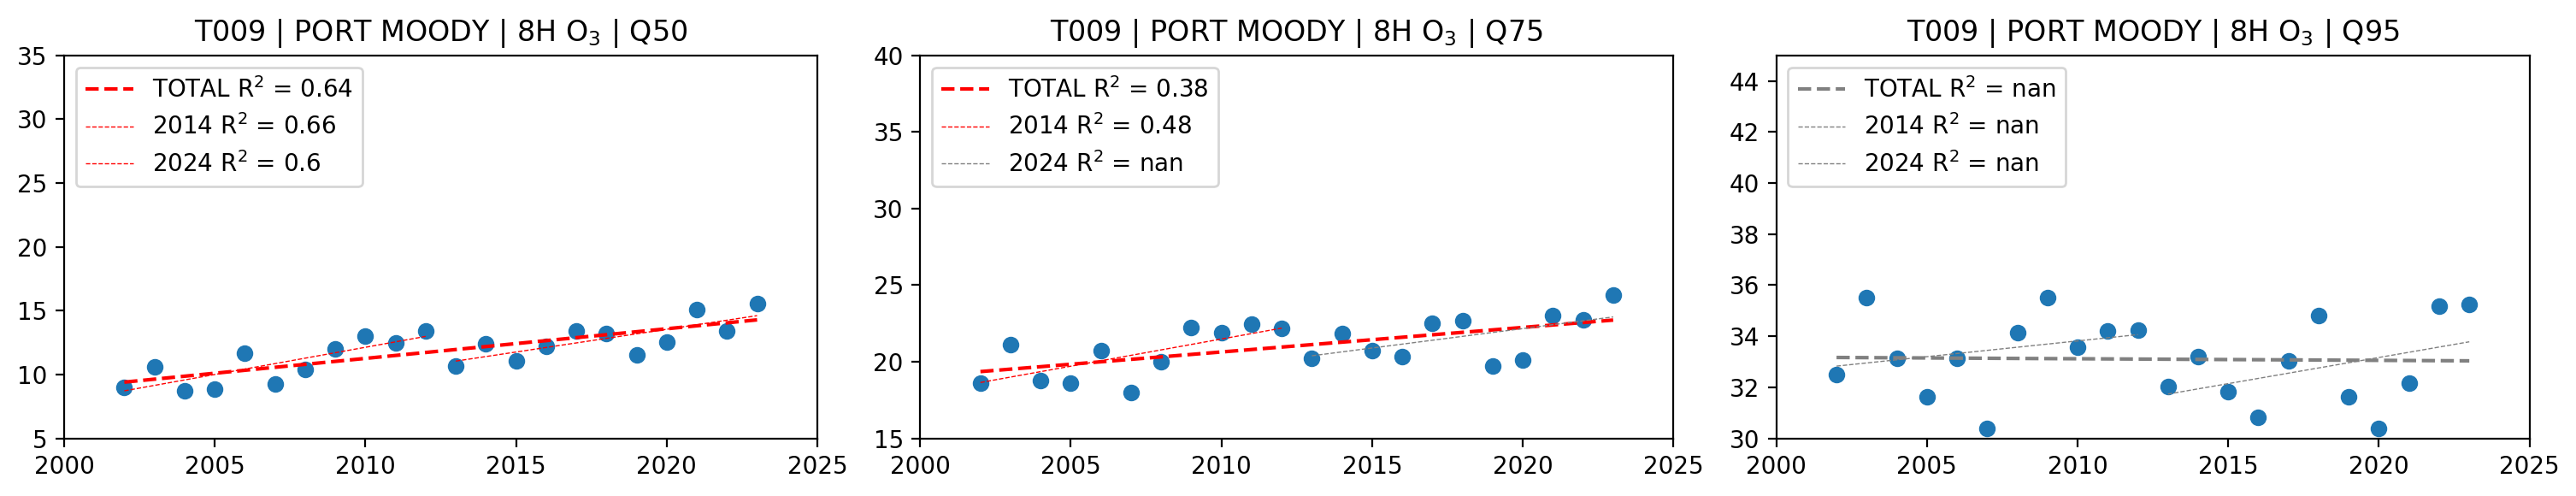

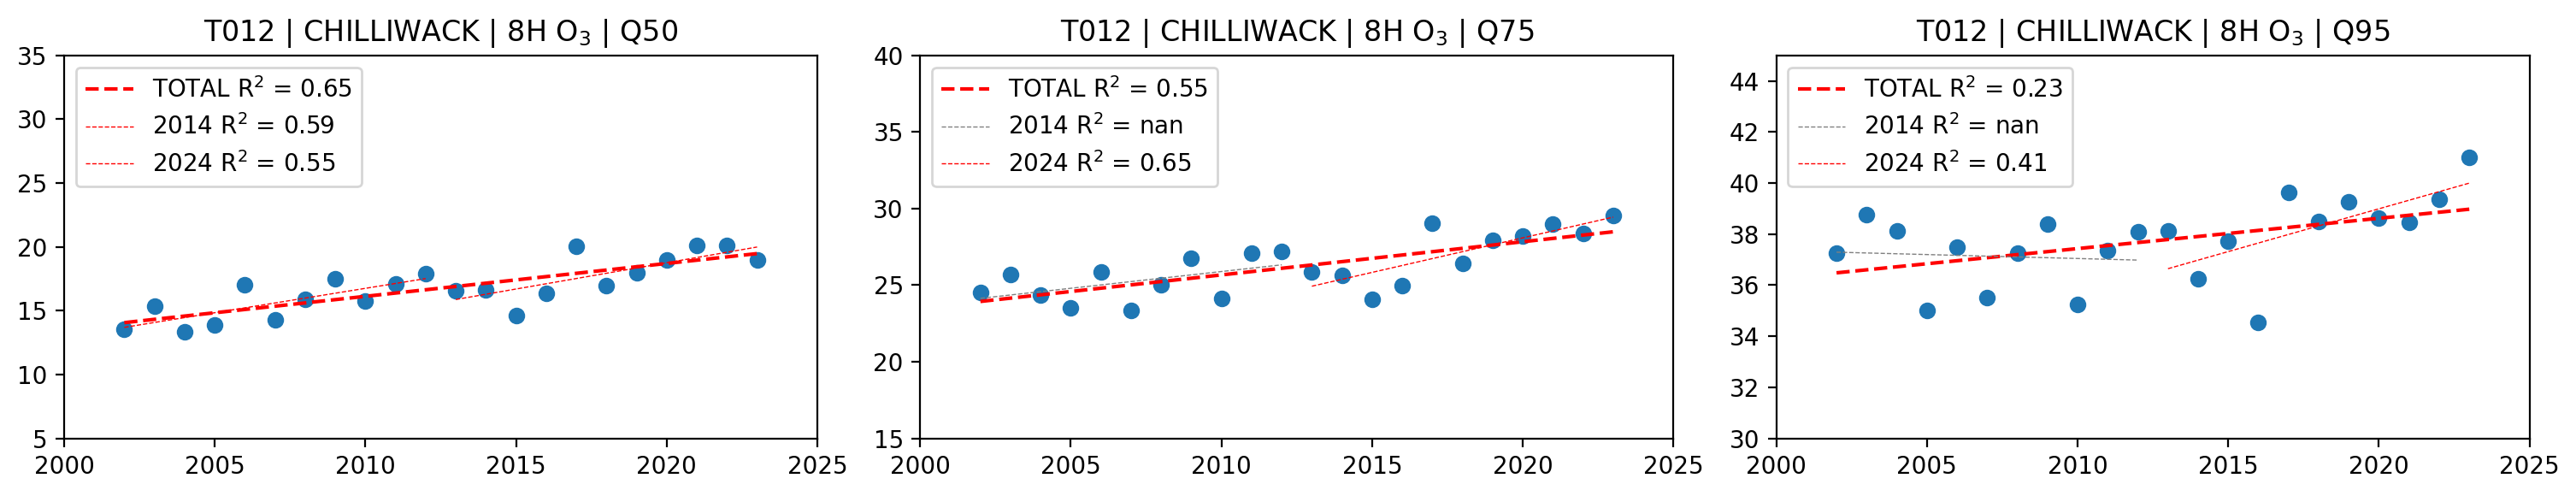

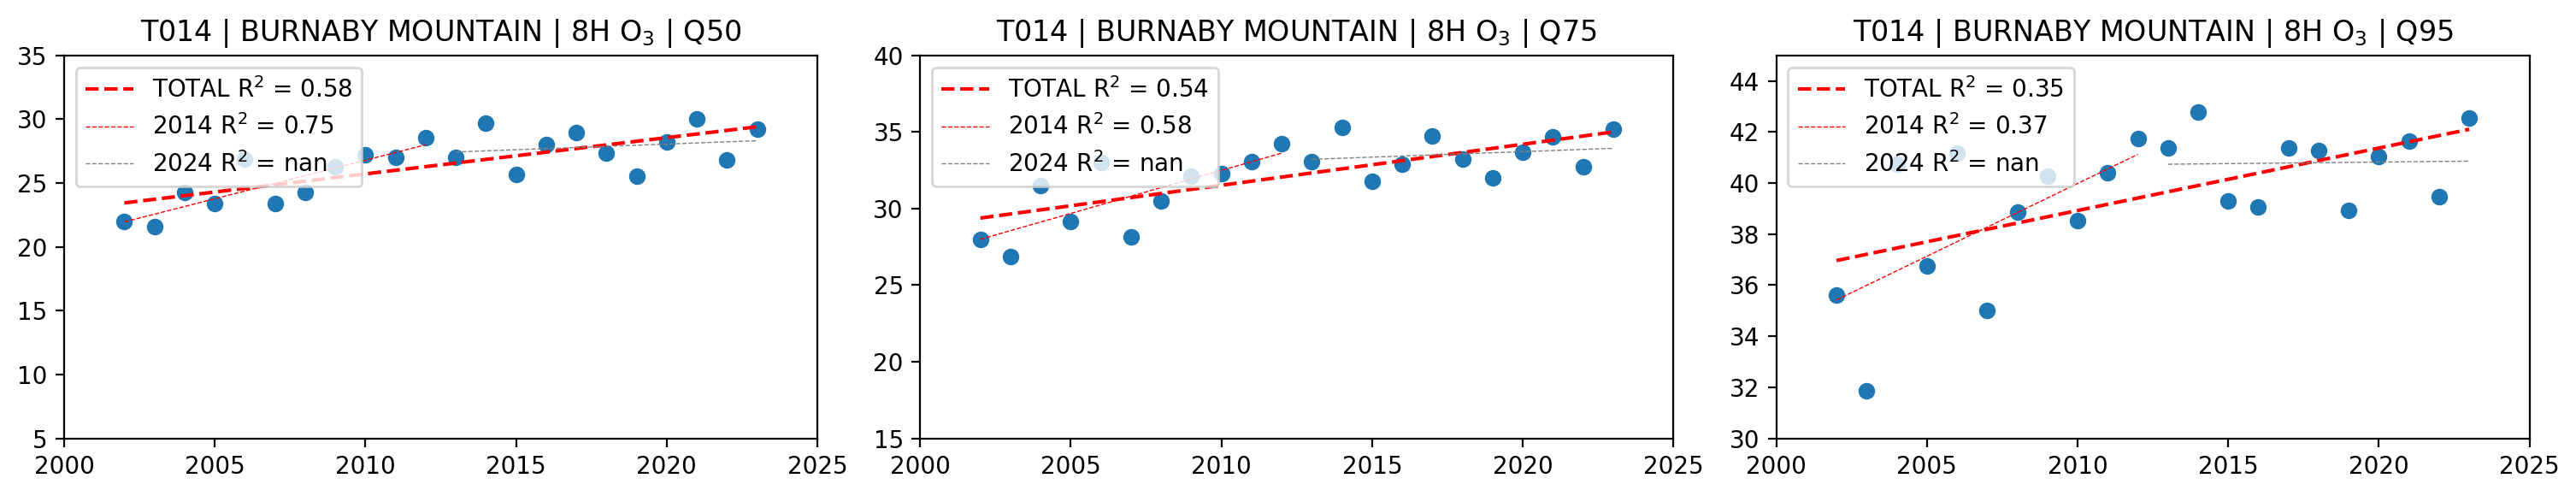

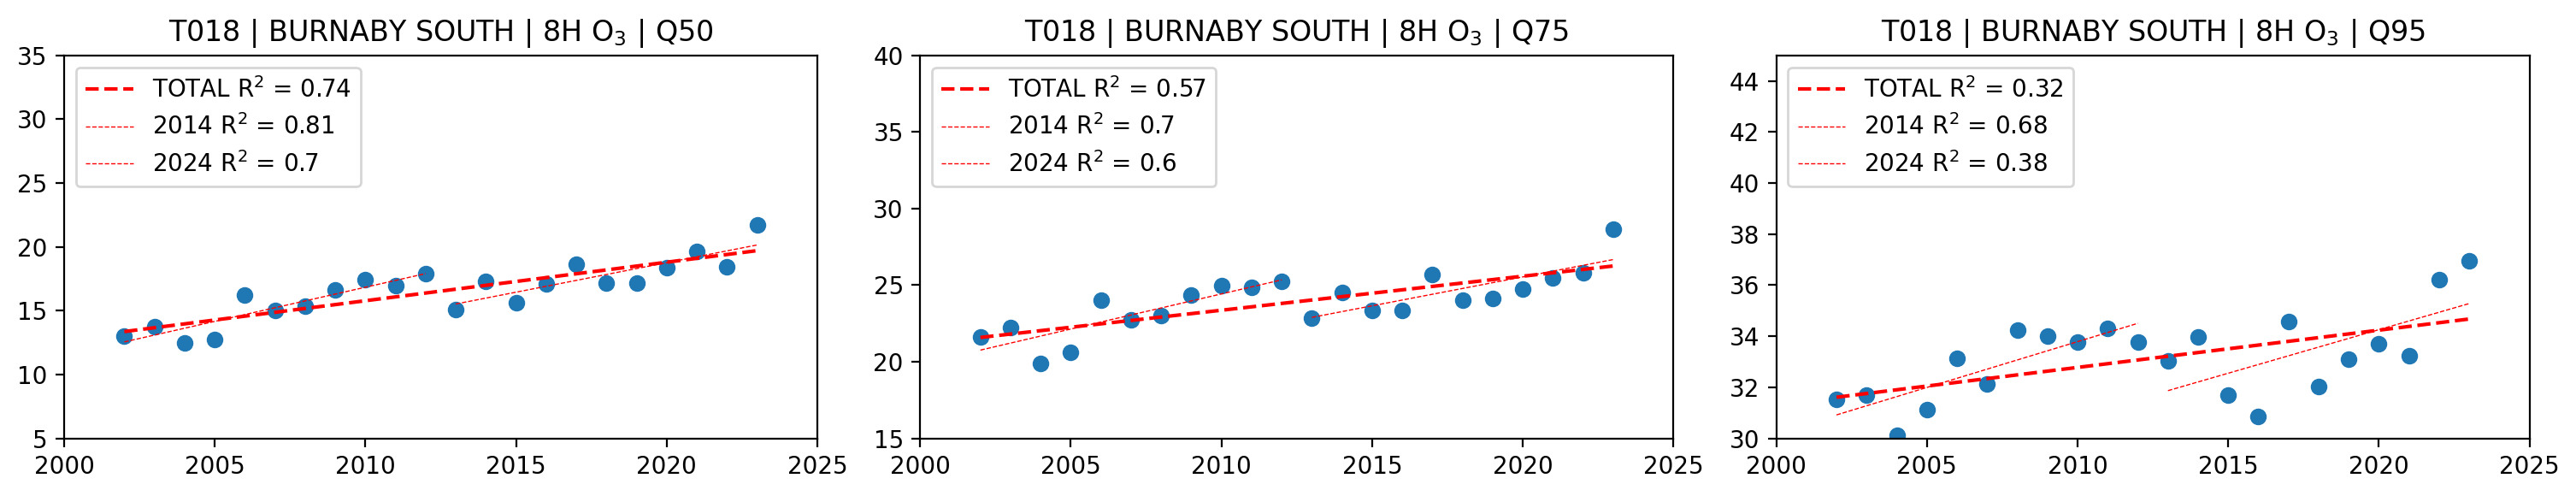

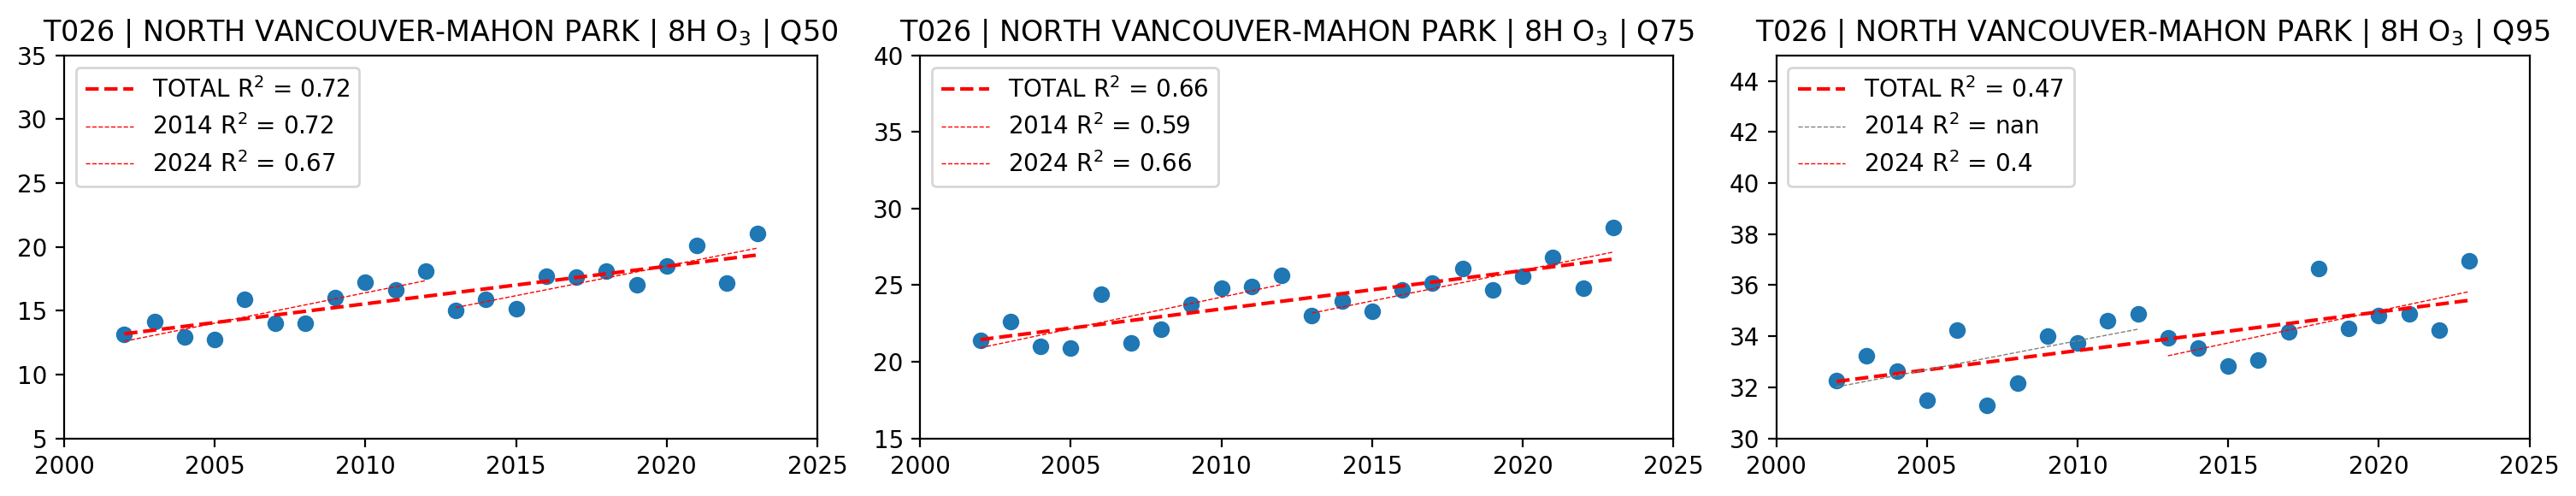

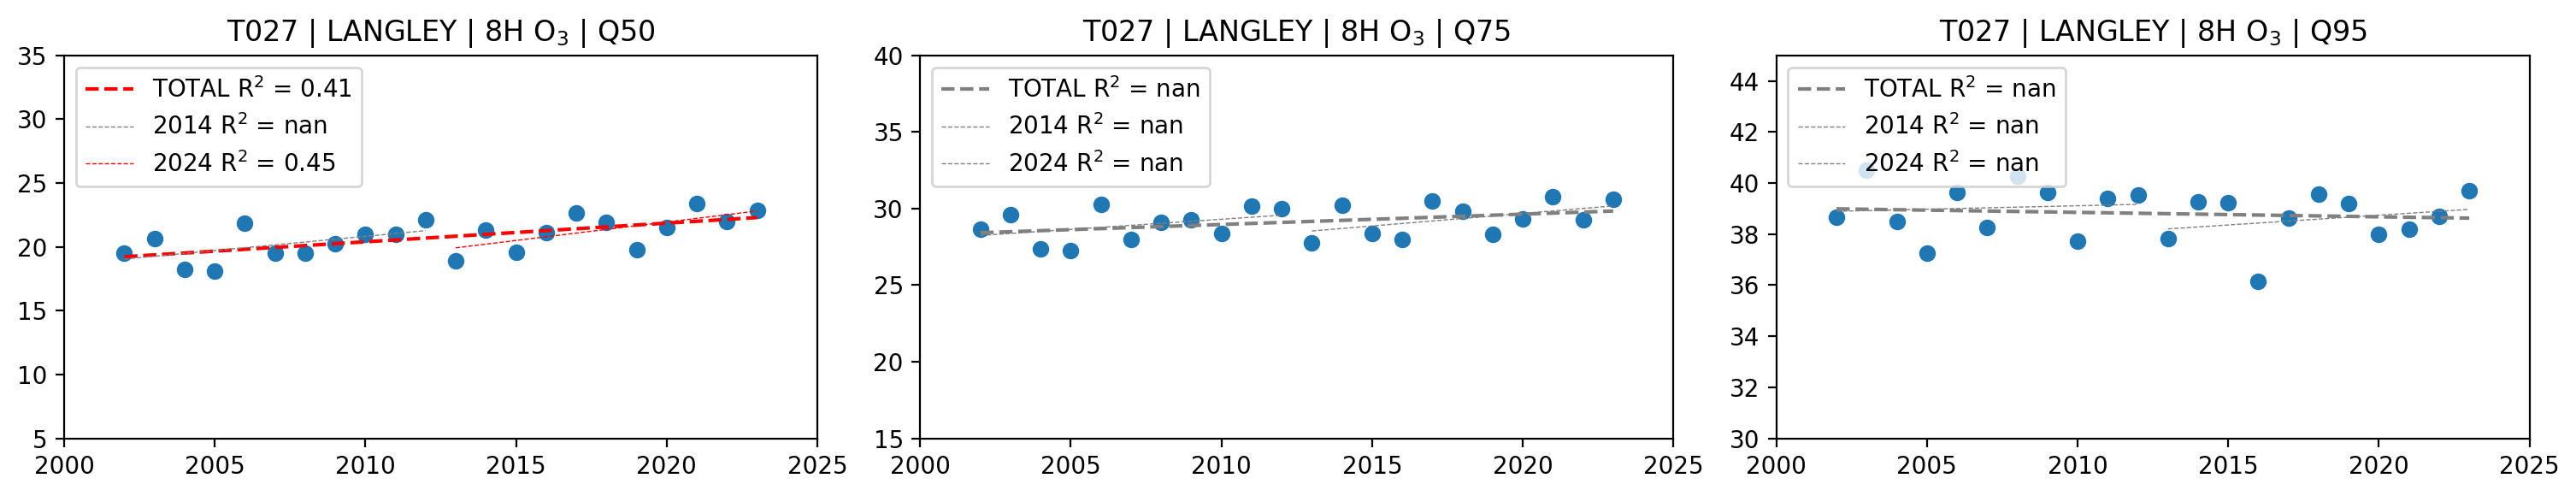

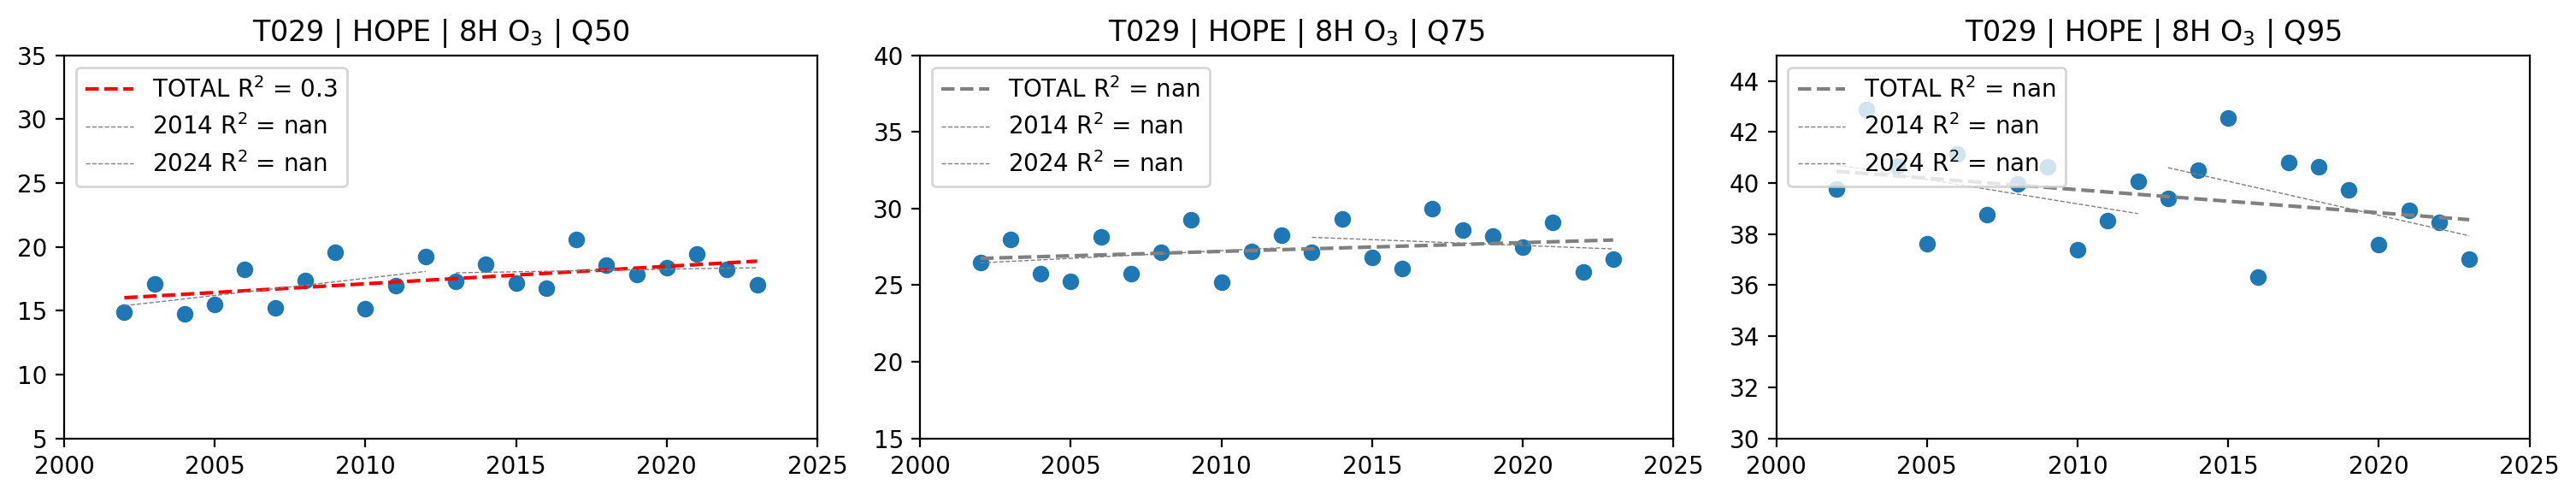

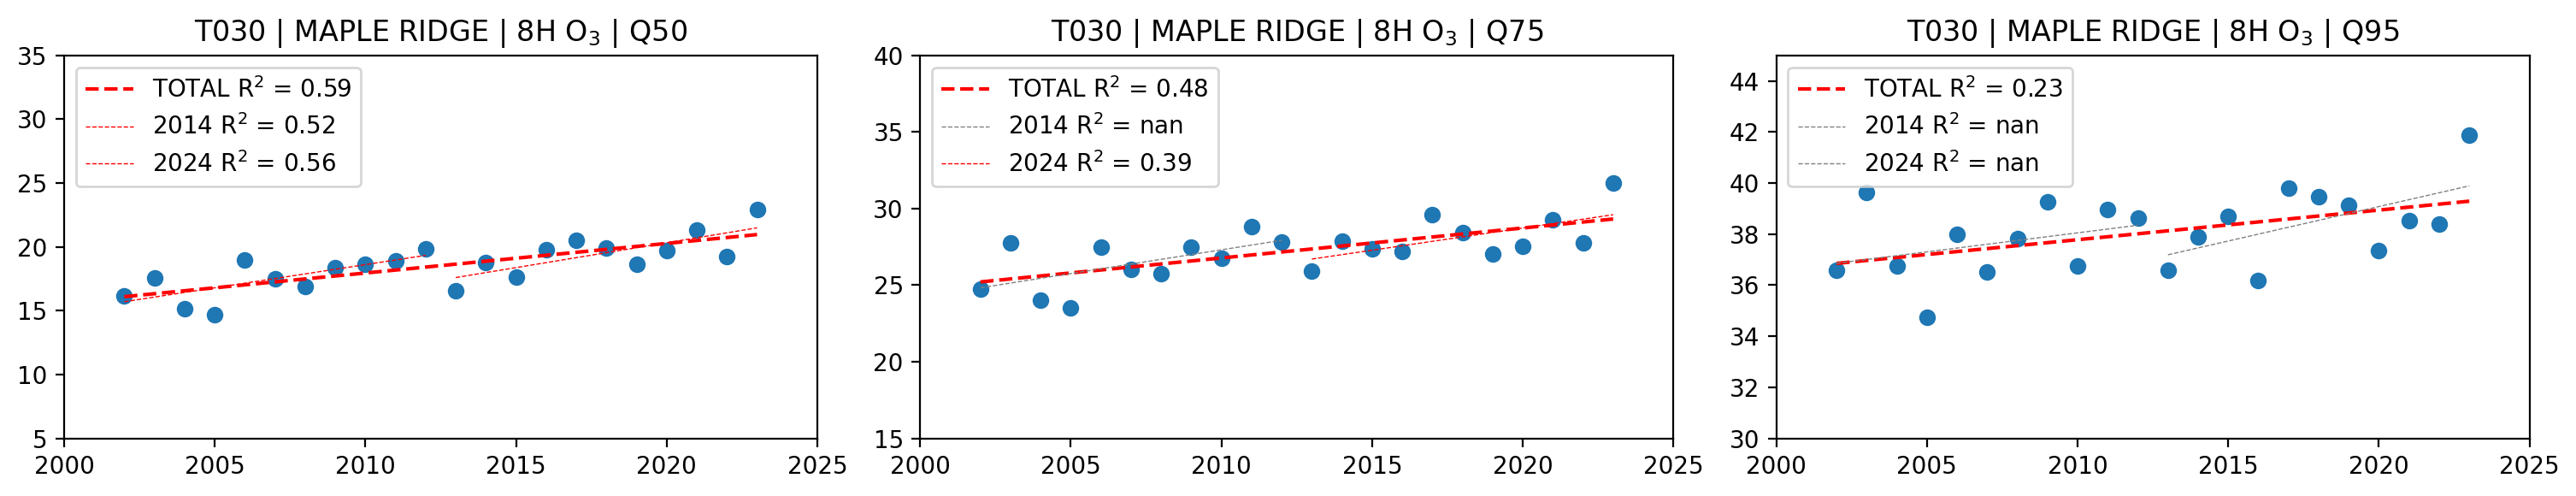

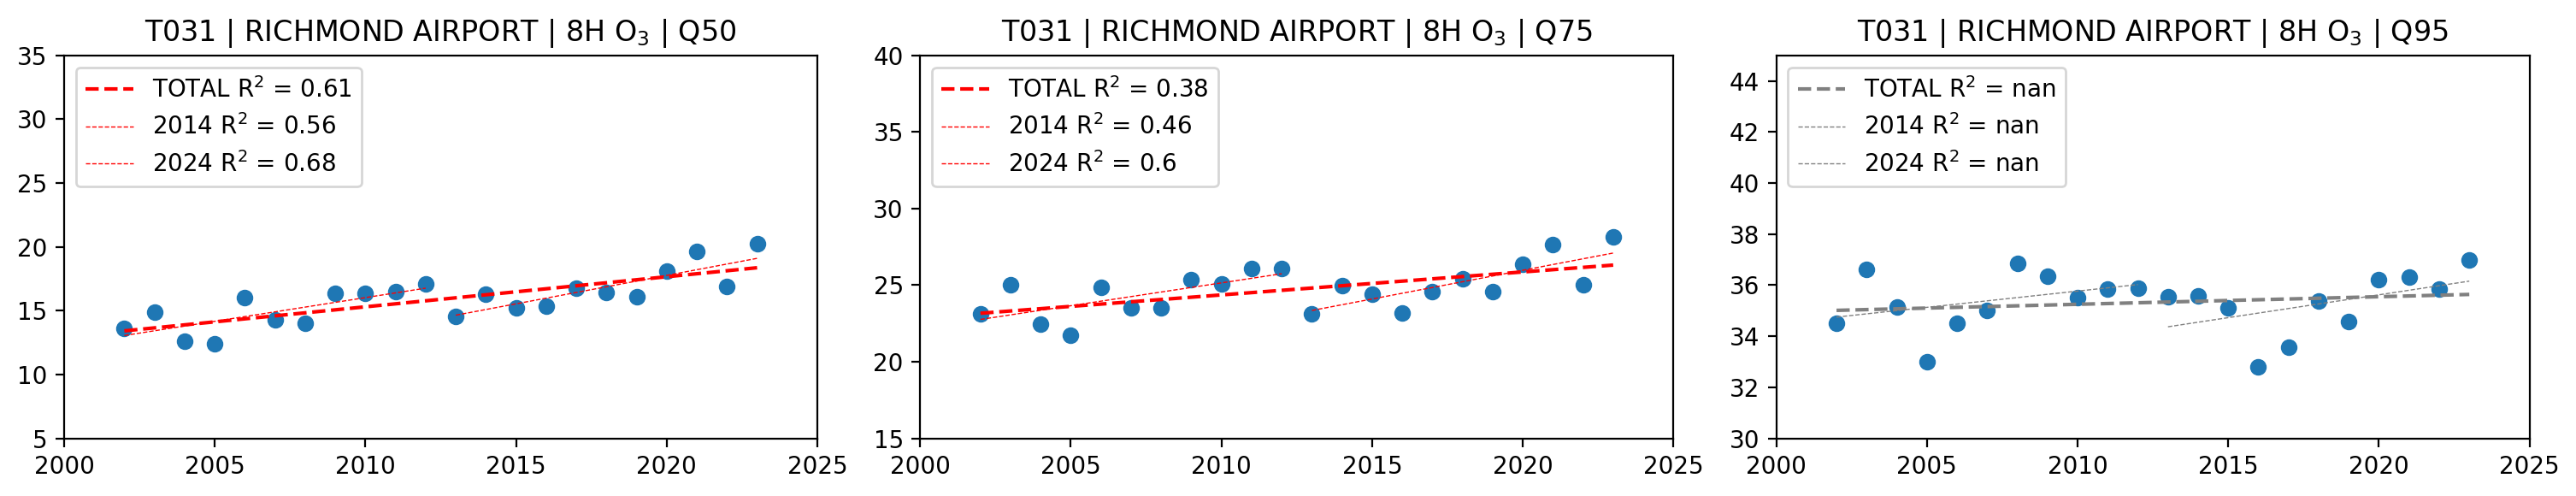

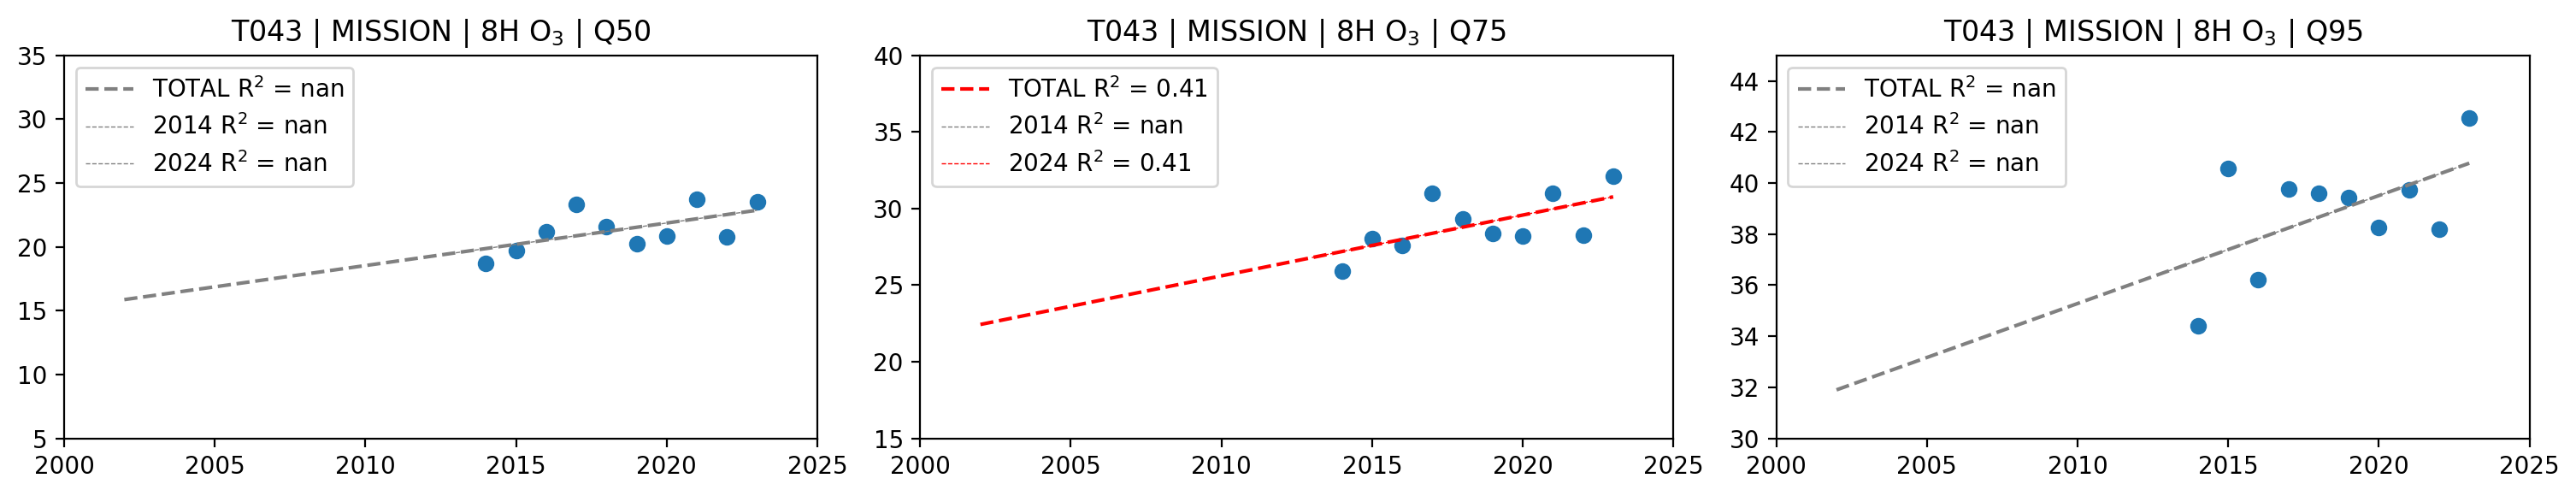

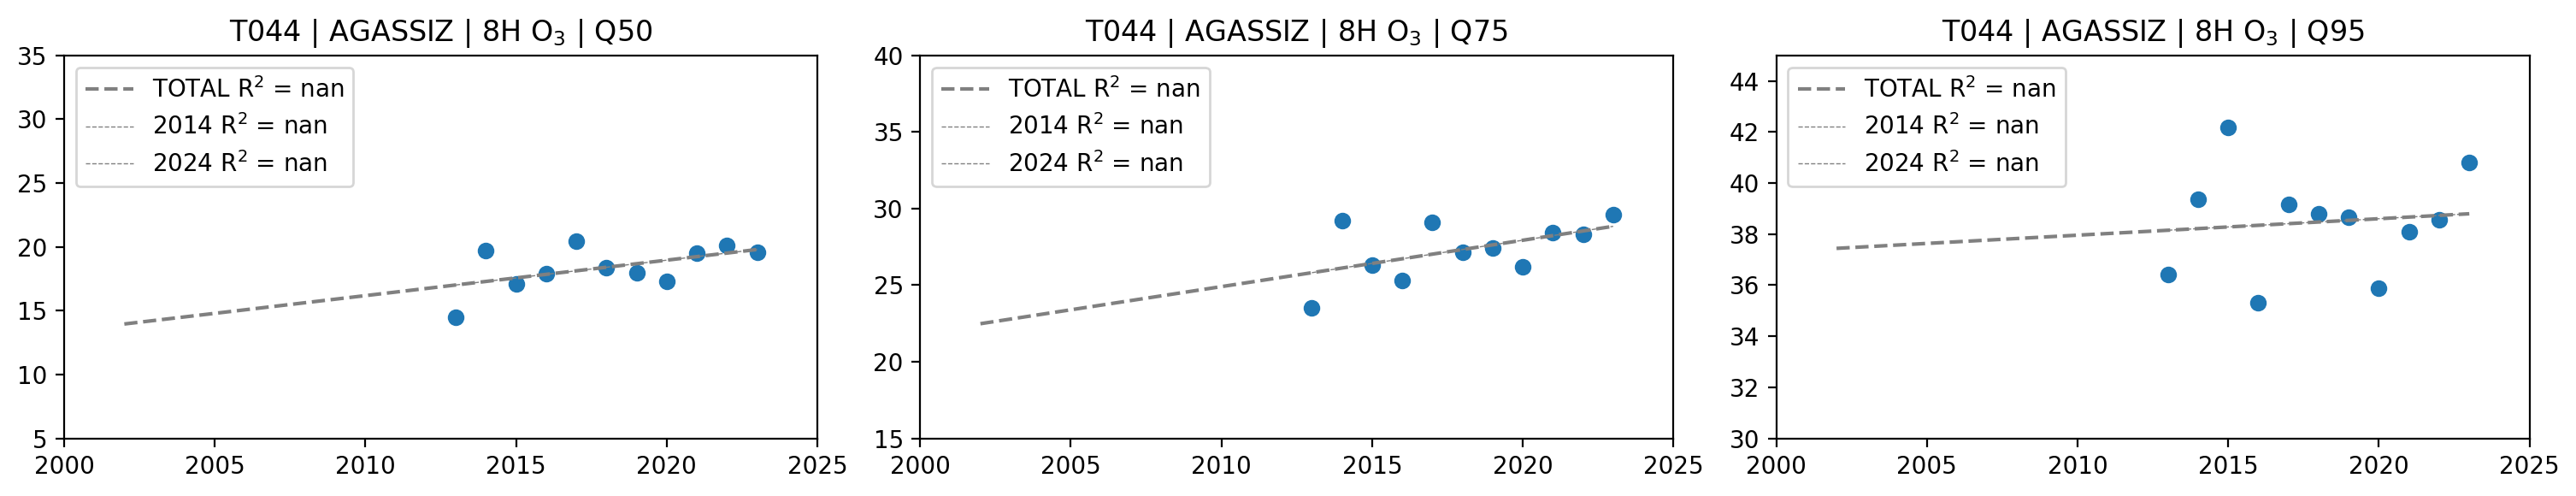

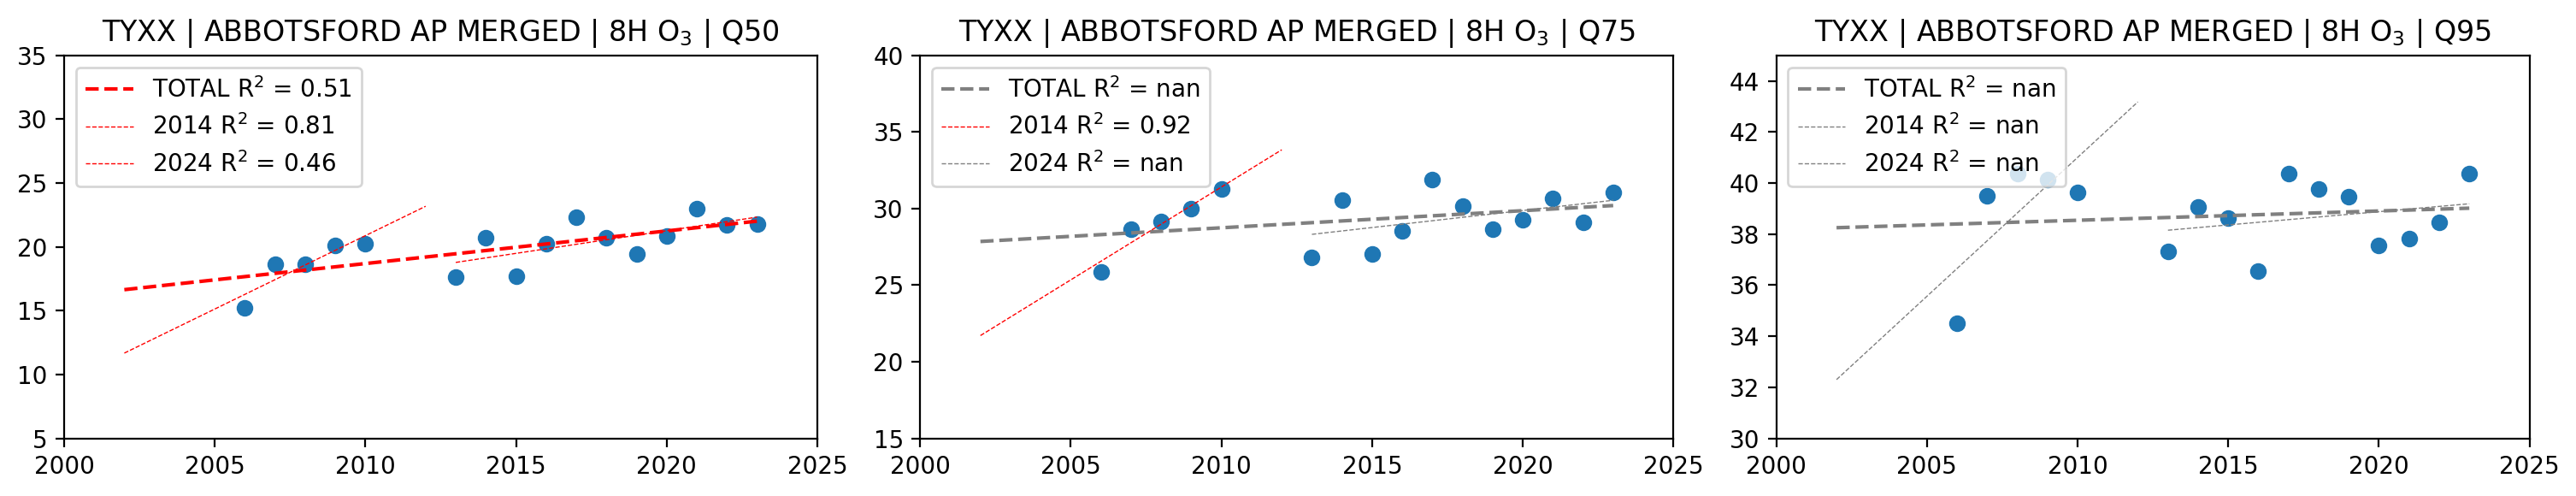

In [97]:
#-------------8H OZONE------------------
#loop through stations
for nStn, stn in enumerate(stations):

  #loop through quantiles
  numQnt = len(quantiles) + 1
  plt.figure(figsize=(5*numQnt,3))
  for nQ, qnt in enumerate(quantiles):

    #gather data
    # q = pd.concat([grp8h2014[stn].quantile(q=qnt), grp8h2024[stn].quantile(q=qnt)])
    q = grp_8h[stn].quantile(q=qnt)

    #------trendline------
    #add constant to predictor variables
    x = sm.add_constant(q.index.values)
    # x = sm.add_constant(q.index.values,has_constant='add')
    # x = q.index.values

    #fit linear regression model
    modelT = sm.OLS(q, x, missing='drop').fit()
    try:
      model2014 = sm.OLS(q[:11], x[:11], missing='drop').fit()
      trend2014 = model2014.predict(exog=x[:11])
    except:
      trend2014 = np.ones(np.shape(q[:11])) * np.nan
      print(f'No 8h data to perform OLS: {stn} for AP2014 Q{int(qnt*100)}')
    try:
      model2024 = sm.OLS(q[11:], x[11:], missing='drop').fit()
      trend2024 = model2024.predict(exog=x[11:])
    except:
      trend2024 = np.ones(np.shape(q[11:])) * np.nan
      print(f'No 8h data to perform OLS: {stn} for AP2024 Q{int(qnt*100)}')
    #get trend for last N years
    trendT = modelT.predict(exog=x)
    #if significant, save the trend
    if modelT.pvalues.x1<0.05:
      trends.loc[stn,f'8h{qnt}'] = modelT.params.x1

    # trend2014 = model2014.predict(exog=x[:11])
    # trend2024 = model2024.predict(exog=x[11:])

    #----plotting-----
    plt.subplot(1,numQnt,nQ + 1)
    ax = plt.gca()
    plt.scatter(y = q, x=q.index)
    plt.plot(x[:,1],trendT,c=['red' if modelT.pvalues.x1<0.05 else 'gray'][0],linestyle='--',\
             label = f'TOTAL R$^2$ = {[round(modelT.rsquared,2) if modelT.pvalues.x1<0.05 else "nan"][0]}')
    plt.plot(x[:11,1],trend2014,c=['red' if model2014.pvalues.x1<0.05 else 'gray'][0],\
             linestyle='--', linewidth = 0.5, \
             label = f'2014 R$^2$ = {[round(model2014.rsquared,2) if model2014.pvalues.x1<0.05 else "nan"][0]}')
    plt.plot(x[11:,1],trend2024,c=['red' if model2024.pvalues.x1<0.05 else 'gray'][0],\
             linestyle='--', linewidth = 0.5, \
             label = f'2024 R$^2$ = {[round(model2024.rsquared,2) if model2024.pvalues.x1<0.05 else "nan"][0]}')
    plt.legend(loc=2)
    # plt.title(f'{stn} | 8H OZONE | Q{int(qnt*100)}')
    ax.set(title = f'{stn} | {meta.loc[stn,"StationName"]} | 8H O$_3$ | Q{int(qnt*100)}', xlim=[2000, 2025], ylim=lmt_8h[nQ])
  plt.tight_layout()
  plt.savefig(os.path.join(fig_path, 'stn_trends','8H',f'{stn}_O3_8H.pdf'),bbox_inches = 'tight')


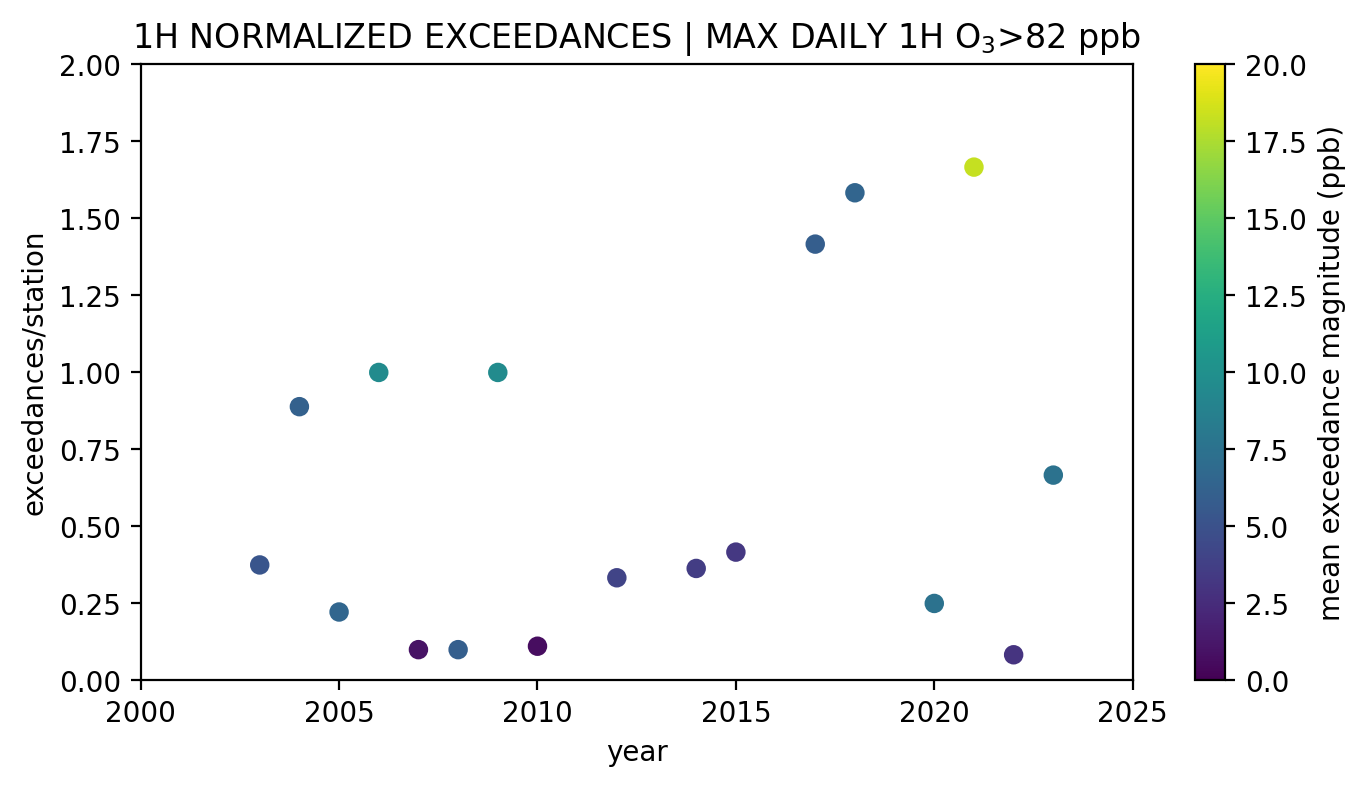

In [99]:
# ------- ANALYSIS OF FREQ AND MAG OF EXCEEDANCE ---------

# --------1h ozone analysis-------
#get daily max for each day of the year within each year
daily_1h_max = ozone_1h.groupby([ozone_1h.index.year,ozone_1h.index.day_of_year]).max()
daily_1h_max.index.set_names(['year','day'], inplace=True)
#get count of exceedances by station and year
ex_cnt_1h = daily_1h_max.gt(82).reset_index(0).groupby('year').agg('sum')
#sum across all stations, weigh by station count
ex_total_1h = ex_cnt_1h.sum(axis='columns')
active_stn = data_frac.gt(0.75).sum(axis='columns')
normalized_ex = ex_total_1h/active_stn
#get average magnitude of exceedance by year
diff_daily_1h = daily_1h_max - 82
diff_daily_1h[diff_daily_1h.le(0)] = np.nan
mag_1h = diff_daily_1h.reset_index(0).groupby('year').agg('mean').mean(axis='columns')

#plot frequency of 1H exceedanes by year
plt.figure(figsize=(8,4))
ax = plt.gca()
plt.scatter(normalized_ex.index, normalized_ex,\
            c=mag_1h, vmin=0, vmax = 20)
ax.set(title = f'1H NORMALIZED EXCEEDANCES | MAX DAILY 1H O$_3$>82 ppb',\
       xlabel = 'year', ylabel='exceedances/station', ylim = [0,2], xlim=[2000, 2025])
plt.colorbar(label = 'mean exceedance magnitude (ppb)')
plt.savefig(os.path.join(fig_path,'1H_O3_NormExceedances.pdf'),bbox_inches = 'tight')

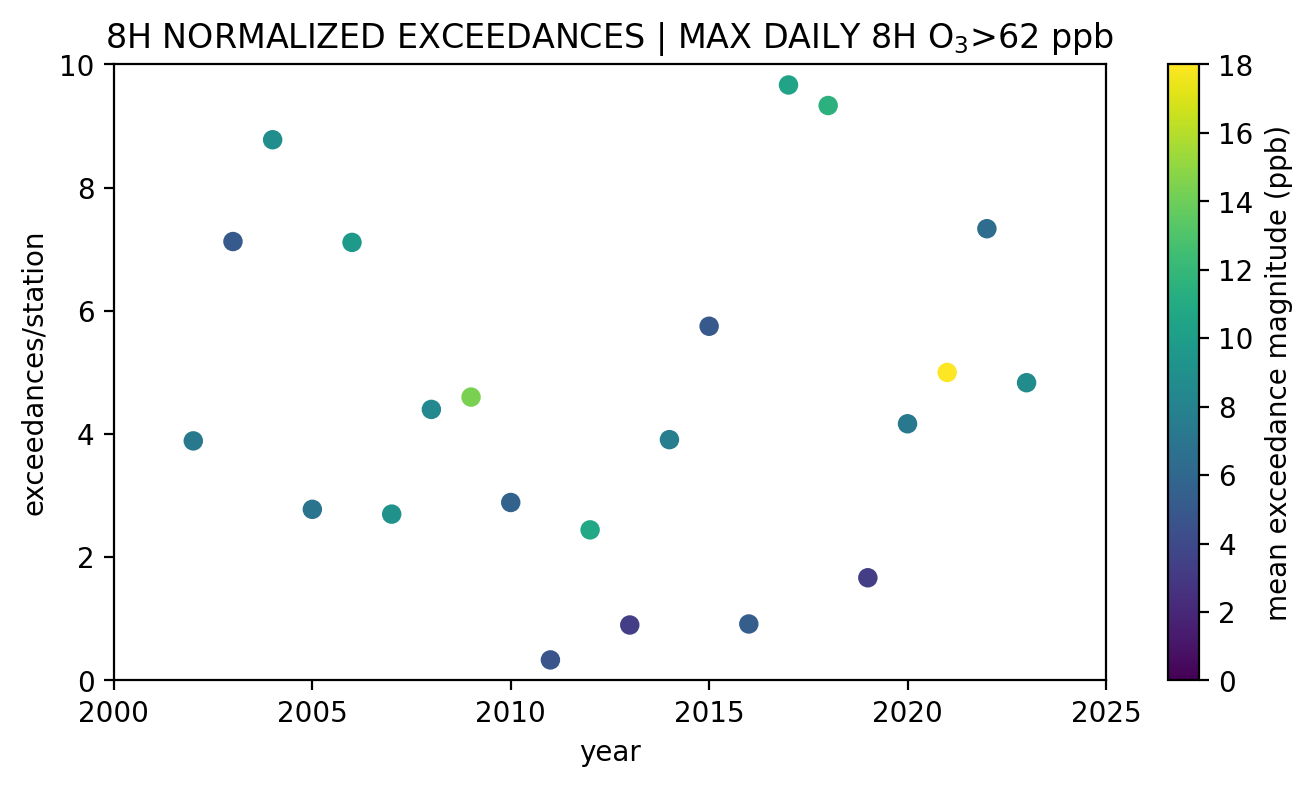

In [100]:
# --------8h ozone analysis-------
#get daily max for each day of the year within each year
daily_8h_max = ozone_1h.groupby([ozone_8h.index.year,ozone_8h.index.day_of_year]).max()
daily_8h_max.index.set_names(['year','day'], inplace=True)
#get count of exceedances by station and year
ex_cnt_8h = daily_8h_max.gt(62).reset_index(0).groupby('year').agg('sum')
#sum across all stations, weigh by station count
ex_total_8h = ex_cnt_8h.sum(axis='columns')
normalized_ex_8h = ex_total_8h/active_stn
#get average magnitude of exceedance by year
diff_daily_8h = daily_8h_max - 62
diff_daily_8h[diff_daily_8h.le(0)] = np.nan
mag_8h = diff_daily_8h.reset_index(0).groupby('year').agg('mean').mean(axis='columns')

#plot frequency of 1H exceedanes by year
plt.figure(figsize=(8,4))
ax = plt.gca()
plt.scatter(normalized_ex_8h.index, normalized_ex_8h,\
            c=mag_8h,vmin=0,vmax=18)
ax.set(title = f'8H NORMALIZED EXCEEDANCES | MAX DAILY 8H O$_3$>62 ppb',\
       xlabel = 'year', ylabel='exceedances/station', xlim=[2000, 2025],ylim=[0,10])
plt.colorbar(label = 'mean exceedance magnitude (ppb)')
plt.savefig(os.path.join(fig_path,'8H_O3_NormExceedances.pdf'),bbox_inches = 'tight')

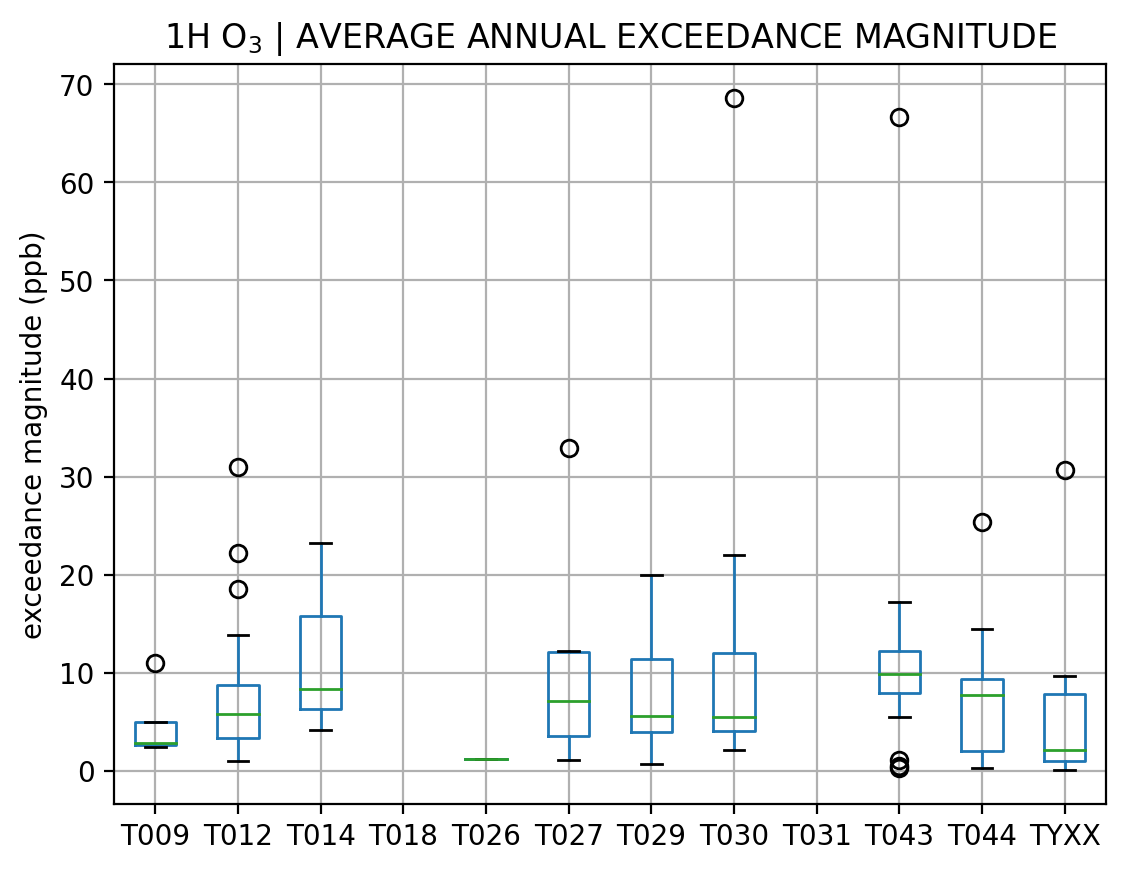

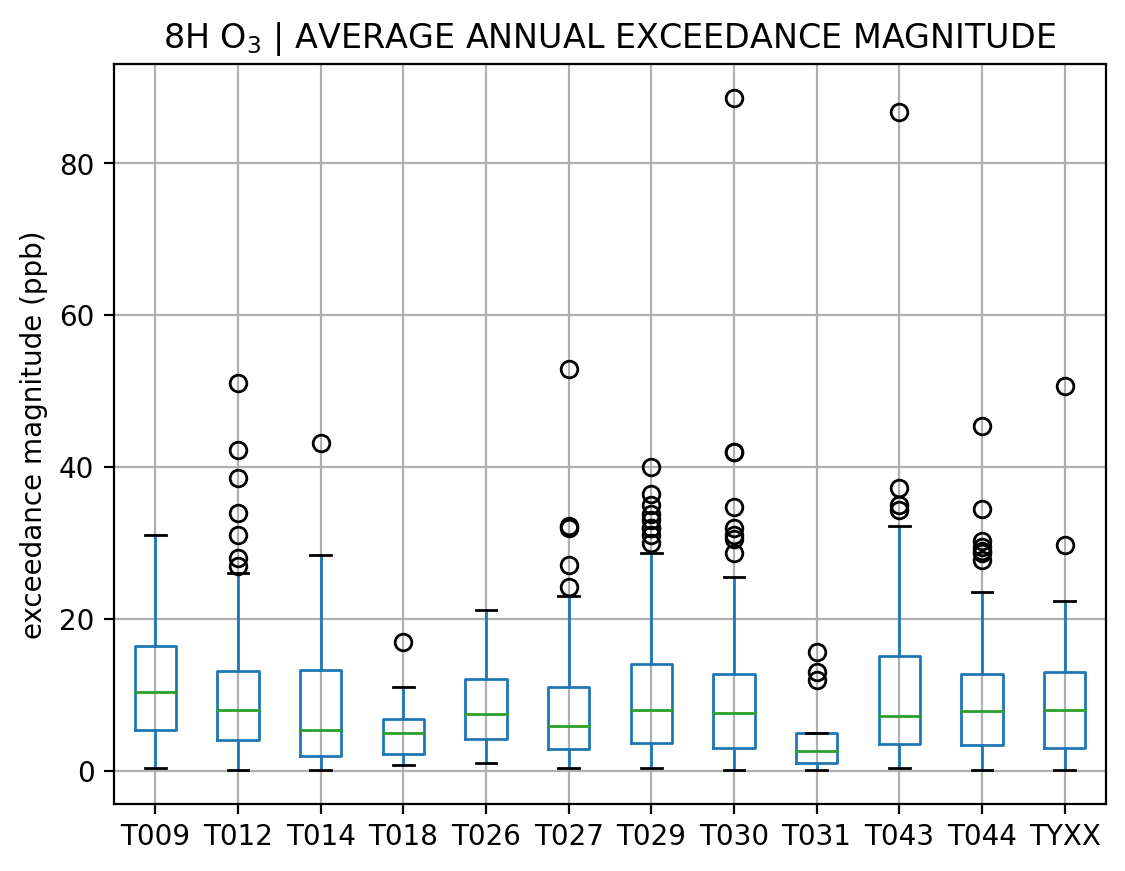

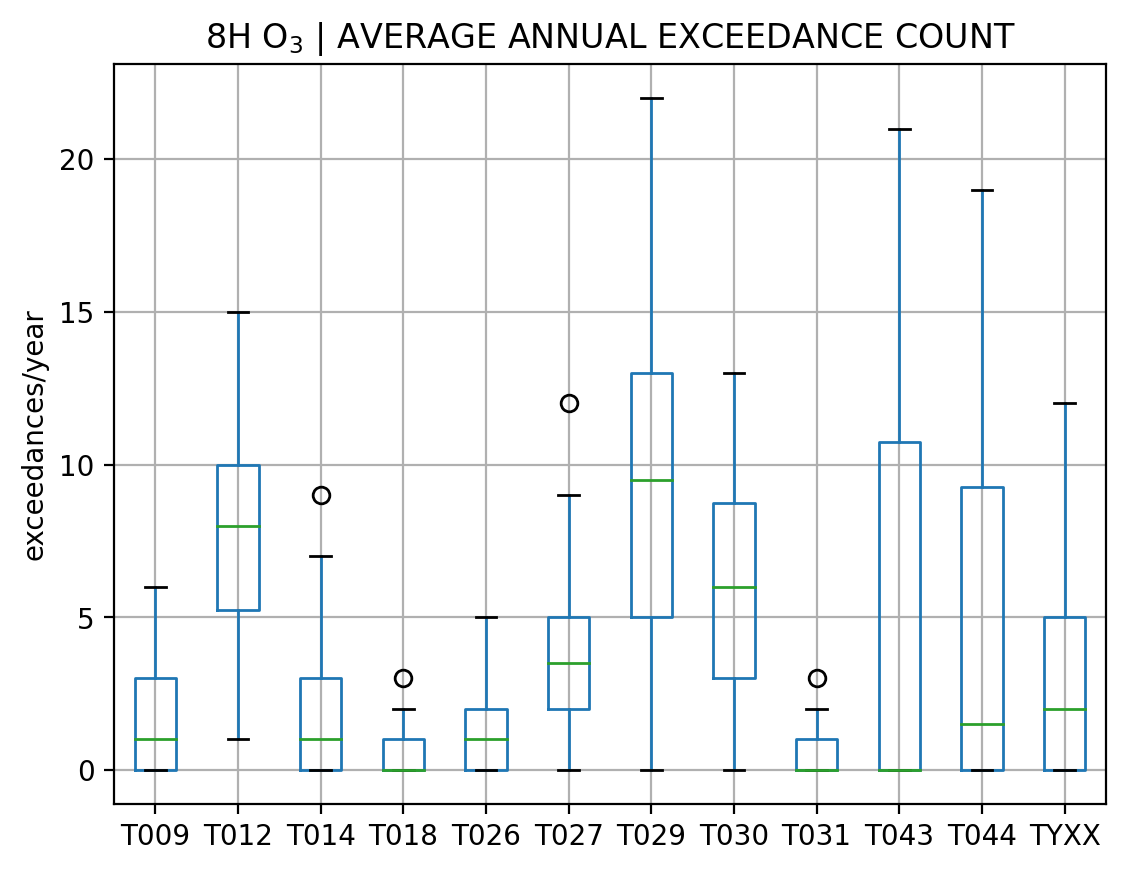

In [137]:
#Boxplots for exeedance counts and magnitudes
#---1h plots------
plt.figure()
diff_daily_1h.boxplot()
plt.gca().set(title='1H O$_3$ | AVERAGE ANNUAL EXCEEDANCE MAGNITUDE', ylabel='exceedance magnitude (ppb)')
plt.savefig(os.path.join(fig_path,'1H_O3_ExceedanceMag_Boxplot.pdf'),bbox_inches = 'tight')

# #too few samples
# plt.figure()
# ex_cnt_1h.boxplot()

#------8h------
plt.figure()
diff_daily_8h.boxplot()
plt.gca().set(title='8H O$_3$ | AVERAGE ANNUAL EXCEEDANCE MAGNITUDE', ylabel='exceedance magnitude (ppb)')
plt.savefig(os.path.join(fig_path,'8H_O3_ExceedanceMag_Boxplot.pdf'),bbox_inches = 'tight')

plt.figure()
ex_cnt_8h.boxplot()
plt.gca().set(title='8H O$_3$ | AVERAGE ANNUAL EXCEEDANCE COUNT', ylabel='exceedances/year')
plt.savefig(os.path.join(fig_path,'8H_O3_ExceedanceCnt_Boxplot.pdf'),bbox_inches = 'tight')



In [77]:
!pip install Cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 58.8 MB/s eta 0:00:00


In [78]:
#set up google tiles - CHECK THIS IS OK TO USE!
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs

class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

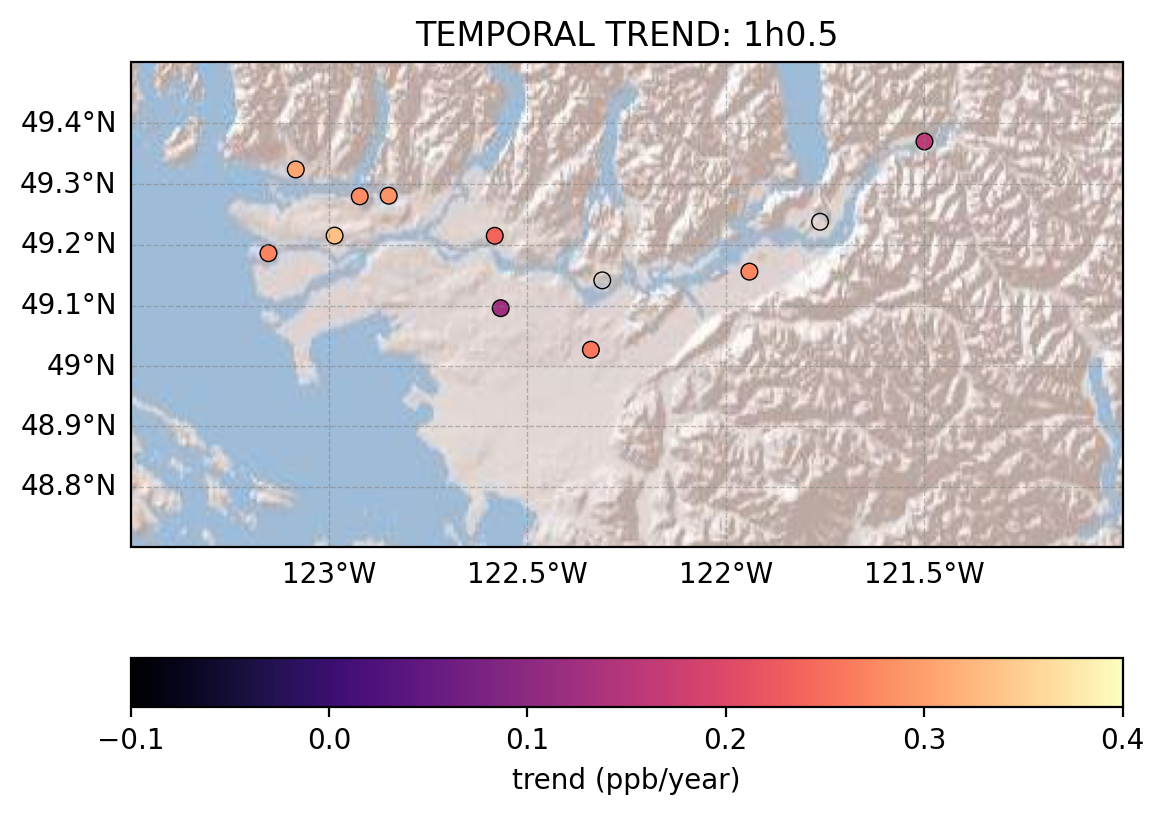

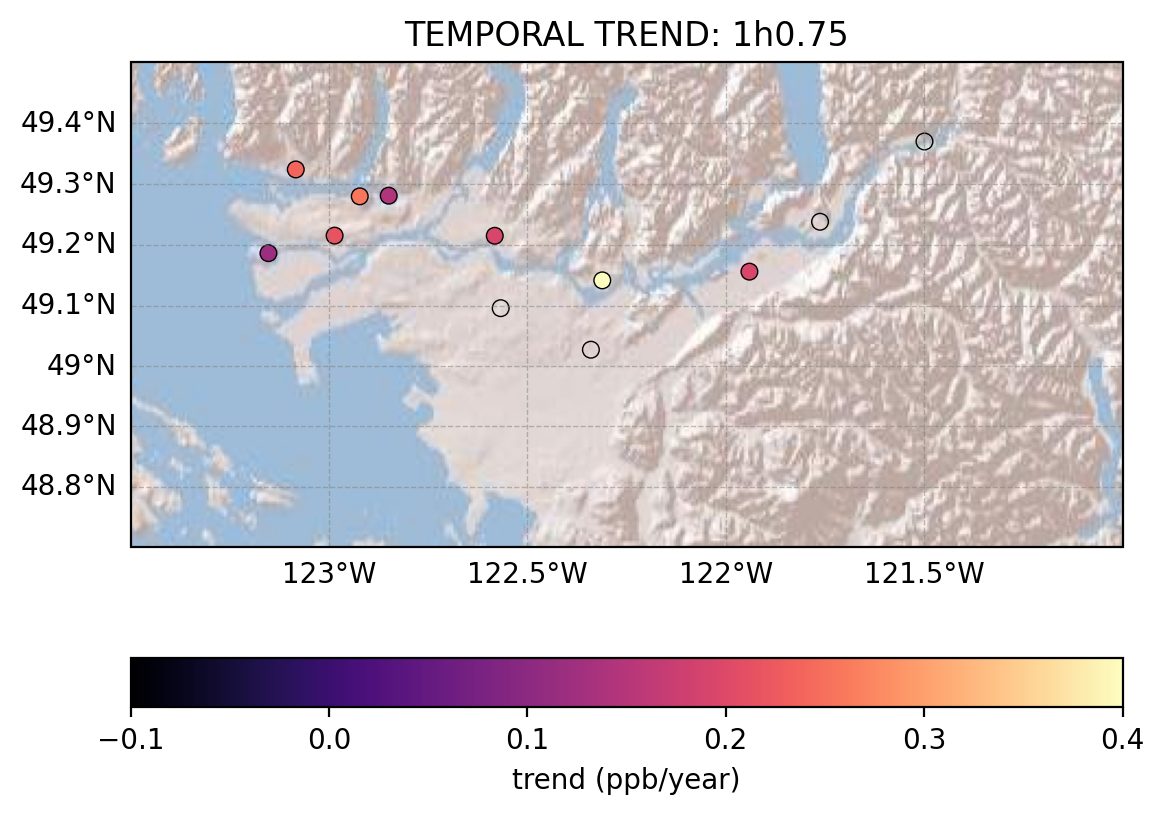

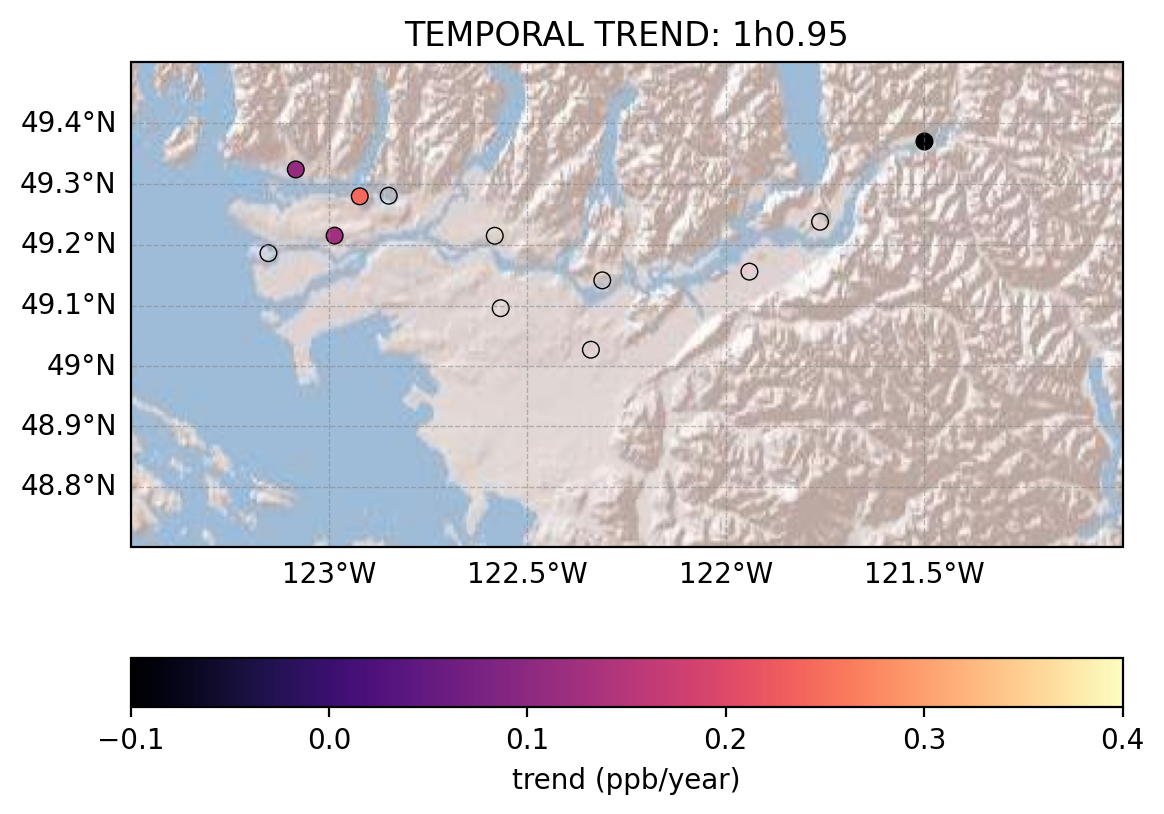

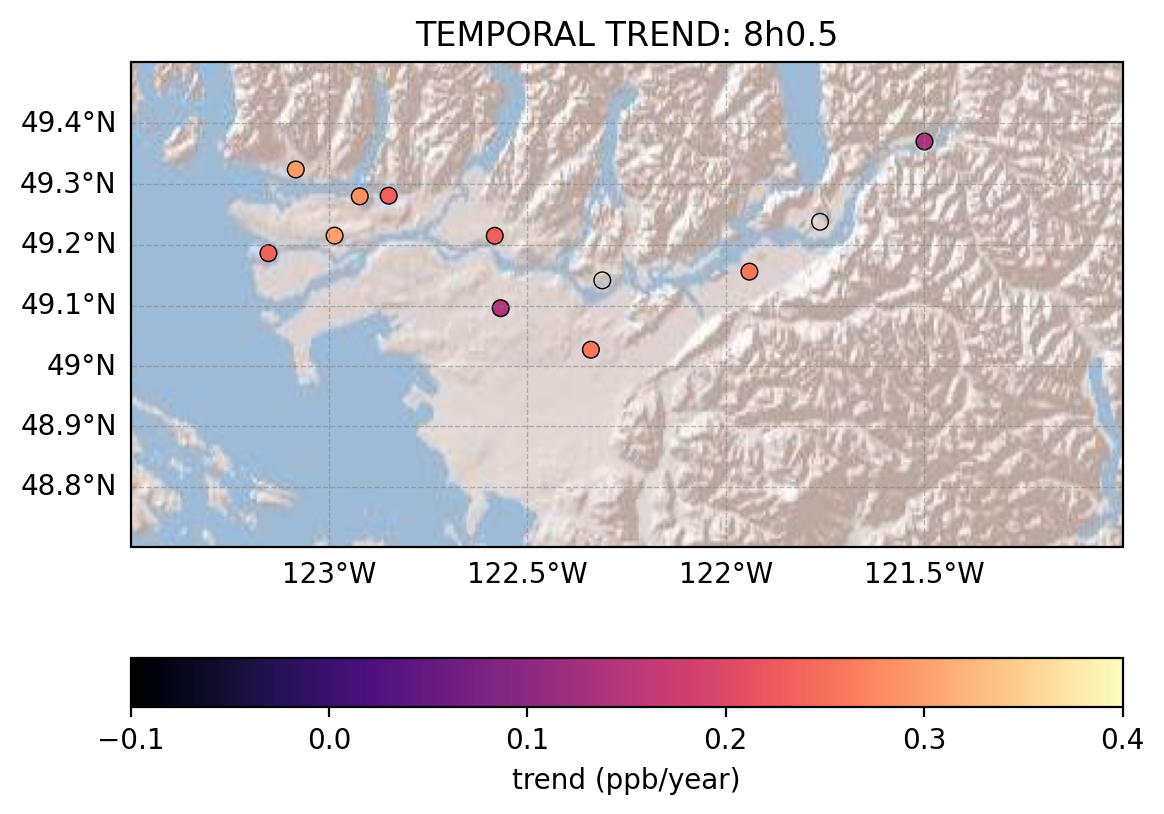

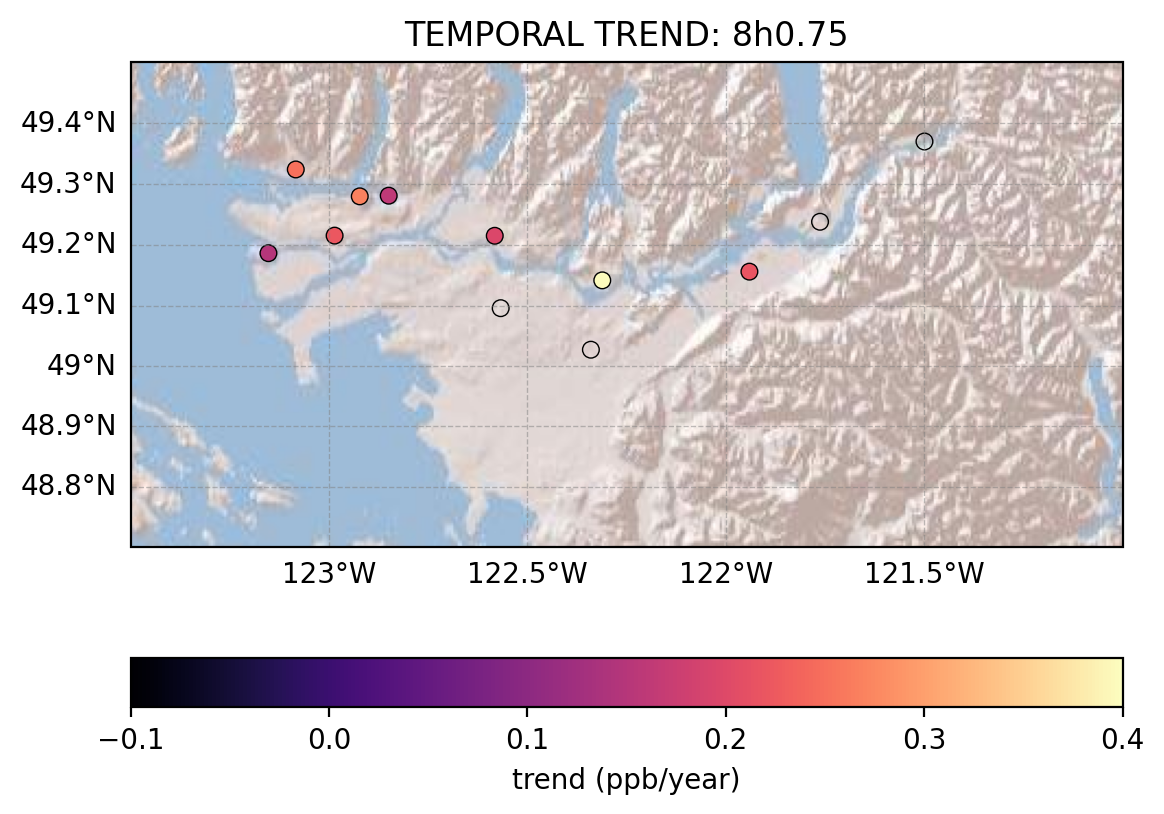

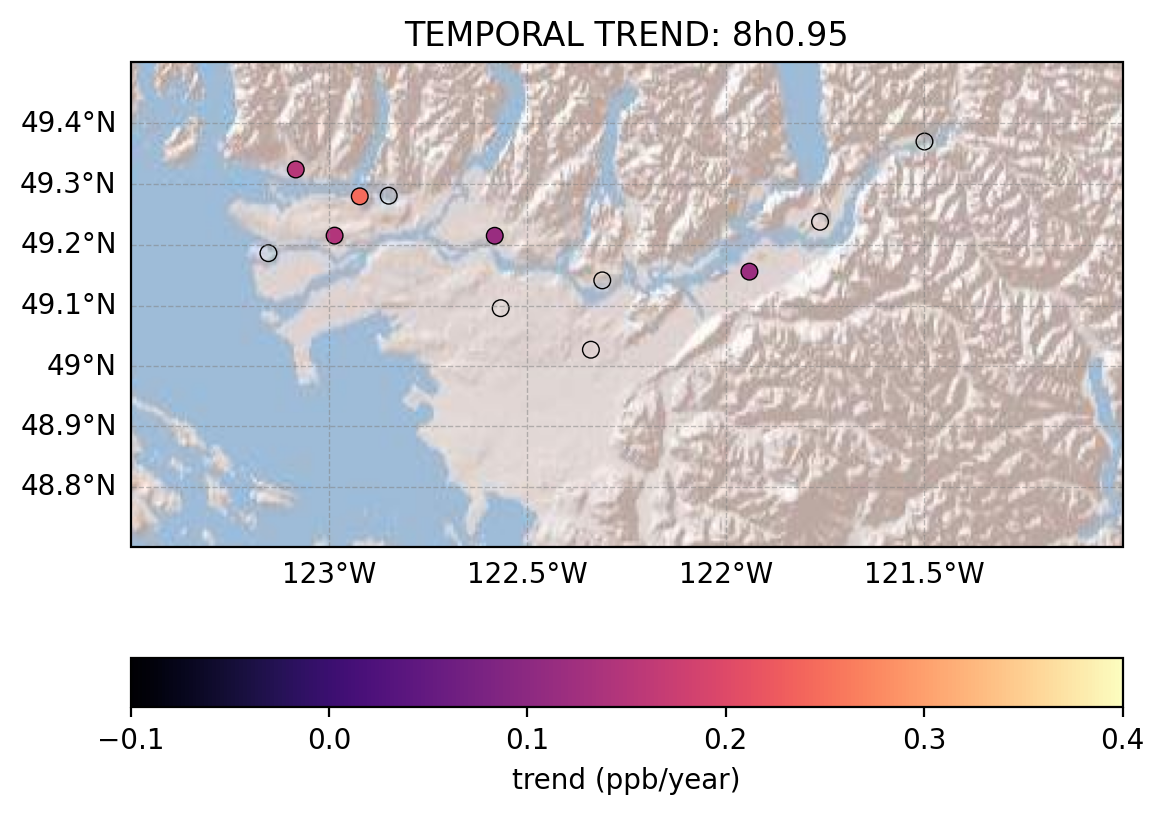

In [83]:
#plot maps of trends
for key in ['1h0.5', '1h0.75', '1h0.95', '8h0.5', '8h0.75', '8h0.95']:
  plt.figure()
  ax = plt.axes(projection=ShadedReliefESRI().crs)
  ax.set_extent([-123.5, -121, 48.7, 49.5])
  ax.add_image(ShadedReliefESRI(), 8)
  scat = plt.scatter(trends.lon.values*-1, trends.lat.values,c=trends[key].values,transform=ccrs.PlateCarree(), \
                     cmap= 'magma',vmin=-0.1, vmax=0.4,edgecolors='black',linewidth=0.5)
  plt.colorbar(label='trend (ppb/year)',orientation='horizontal')
  gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
  gl.top_labels = False
  gl.right_labels = False
  ax.set(title=f'TEMPORAL TREND: {key}')
  plt.savefig(os.path.join(fig_path,'map_trends',f'{key}_O3.pdf'),bbox_inches = 'tight')

In [140]:
#BACKGROUND OZONE ANALYSIS

import requests

# site ID 53-009-0013
# Latitude	48.297860
# Longitude	-124.624910

#API info
url = 'https://aqs.epa.gov/data/api/sampleData/bySite?email=nadya.moisseeva@hawaii.edu&key=ochrebird34&'




In [ ]:
api_call = f'{url}param=44201&bdate=20060101&edate=20061231&state=53&county=009&site=0013'
print(api_call)
response = requests.get(api_call)
obs = response.json()
# if obs['Header'][0]['rows'] == 0:
#   print(f'No EPA data found for period {bdate} - {edate}')
#   continue

hourly_obs = [i for i in obs['Data'] if i['sample_frequency']=='HOURLY']
df = pd.DataFrame(hourly_obs)
df['datetime'] = pd.to_datetime(df['date_gmt'] + ' ' +  df['time_gmt'])
df.drop(labels=['state_code', 'county_code', 'site_number', 'parameter_code', 'poc', 'latitude', 'longitude', 'datum', 'parameter', 'date_local', 'time_local','date_gmt','time_gmt', 'units_of_measure_code', 'sample_duration', 'sample_duration_code', 'sample_frequency', 'detection_limit', 'uncertainty', 'qualifier', 'method_type', 'method', 'method_code', 'state', 'county', 'date_of_last_change','cbsa_code'], axis = 1, inplace=True)
df.set_index('datetime', inplace=True)
# df['station'] = stn

NOTES:

https://www2.gov.bc.ca/assets/gov/environment/air-land-water/air/reports-pub/prov_air_qual_objectives_fact_sheet.pdf
Ozone (O3)
1-hour  82 NAAQO9 1989
8-hour 62 2020 CAAQS* 2013

*https://gazette.gc.ca/rp-pr/p1/2013/2013-05-25/html/notice-avis-eng.html


Questions to consider:

* Achievement based on annual 4th highest daily maximum 8-hour average concentration, averaged over three consecutive years. We originally excluded this with Bruce. Reconsider?

* stations included in EC analysis, but not provided by MV :
  ec_missing = ['T001','T002','T004','T006','T013','T015','T017','T033']

* MV_stns = ['T009','T012','T014','T018','T026','T027','T029','T030','T031','T034/035','T043','T044']

* overlapping EC_stns = ['T009','T012','T018','T026','T027','T029','T030','T031','T034/035']

* 'T014' was previously excluded


Spatial Analysis:
* 8h - Q95, no point, only 5 sig trends



